# <center>CREADO POR JORGE CARDONA</center>

# Inicio de toma de tiempo de ejecucion del Notebook

In [1]:
#libreria time para medir tiempos de ejecucion
import time 

# toma el tiempo antes de ejecutar todo el notebook
tiempo_inicial_ejecucion_notebook = time.time()

# <center>CONFIGURACIÓN GLOBAL DEL NOTEBOOK</center>

In [2]:
# configura el notebook para que las celdas tomen todo el ancho de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# <center>CARGA DE LIBRERÍAS</center>

In [3]:
# oculta los warnings del notebook
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

#importo numpy para hacer uso de sus operaciones con datos de tipo matriz
import numpy as np

# importo libreria para tratar los datos como tablas
import pandas as pd

# convierte cadena a diccionario
import ast
from collections import Counter

# libreria para datos al aleatorios
import random as rd

# libreria para recorrer listas, agruparlas y eliminar elementos repetidos en lista de listas
import itertools

In [4]:
# importo bibliotecas para graficos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from pylab import rcParams

In [5]:
# importo librerias para preprocesamiento de datos
from sklearn import datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Importa la funcion que permite dividir el set de datos
from sklearn.model_selection import train_test_split

#Importo las metricas del modulo de scikit-learn para obtener los datos que me permiten medir el modelo
from sklearn import metrics

#Importo la libreria para hacer croos validation
from sklearn.model_selection import cross_val_score

#Importo los modelos de clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [6]:
# instalar imbalanced-learn con permisos de administrador
# conda install -c conda-forge imbalanced-learn
# importo librerias para procesamiento de datos desbalanceados
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

In [7]:
# libreria para procesamiento en paralelo
import threading

# importa las librerias que permiten usar la computacion paralela
import multiprocessing

# importa liobrerias para trabajar concurrencia
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

# <center>1. DECLARACIÓN DE VARIABLES PARA DATASETS, CLASIFICADORES Y CONSTANTES DEL EJERCICIO</center>

# Nombres de datasets

In [8]:
# define el nivel de precision con que se muestran los datos en las columnas
#pd.set_option("display.precision", precision)

# archivo_base_entrenamiento = "Champions.xlsx"
archivo_base_entrenamiento = "Base_entrenamiento.csv"

# archivo que contiene la informacion con la cual se va a medir el modelo
archivo_base_aprobacion    = "Base_prueba.csv"

# Configuracion de Pandas

In [9]:
# consume mucha memoria si tiene muchas columnas
# no aconsejado cuando tiene muchas filas, puede duras minutos cargando y hace el tamaño del notebook muy grande
# permite que el dataframe muestre todas las columnas
pd.set_option('display.max_columns', None) 

# permite que el dataframe muestre todas las filas
#pd.set_option('display.max_rows', None) 

# Clasificadores, caracteristicas esperadas de los clasificadores y criterio de ordenamiento de los resultados de los clasificadores

In [10]:
# define las tecnicas con las cuales se va a realizar la normalizacion
listado_tecnicas_de_normalizacion = ['min_max_scaler', 'standard_scaler', 'normalizer_l1', 'normalizer_l2']

# son los clasificadores que se van a usar en el analisis
normales      = ['MLP','GB','NB','KNN','RF','DT','LR']
balanceadores = ['BB','AD','ST','STE','RS','NM','LRP']

#evita que existan clasificadores repetidos en la lista
clasificadores = normales + balanceadores

# son los nombres de los valores que se esperan del clasificador
columnas_esperadas_del_clasificador = ['clasificador', 'area_bajo_la_curva', 'promedio_de_validez','promedio_validacion_cruzada']

# bajo esta variable se va a realizar la eleccion del mejor clasificador
criterio_de_clasificador = 'promedio_de_validez'

# Variable objetivo, limite de decision, criterio de descarte, precision, tamaño conjunto de entrenamiento, cantidad de validaciones

In [11]:
# con este realizo el descarte de dimensiones que superen este valor
# este valor permite dividir el dataset original y crea 2 datasets entrenamiento y verificacion, para pruebas
limite_de_decision = 95

# es el limite de disminucion en el rando de eleccion de los clasificadores
# por ejemplo sino encuentra un clasificador con un limite de precision igual o superior al limite de decision
# se descuenta en la tolerancia_de_decision, si el limite_de_decision es 95 y no encuentra, enmtonces disminuye en 
# tolerancia_de_decisionpor ejemplo de 10, entonces busca los mayores o guales a 85, si no encuentra baja a 75, 65, 55..
tolerancia_de_decision = 25

# valor que permite eliminar las columnas que sean mayor o igual al criterio de descarte porcentual
criterio_de_descarte = limite_de_decision

# define la cantidad de numeros decimales con que se mostraran los datos
precision = 3

# define el valor con el cual se van a trabajar los datos
# estas variables deben tener un valor de tipom porcentual entre 1 hasta 100
# define el tamano con que se va a dividir el dataset pata los clasificadores
tamano_conjunto_de_entrenamiento = 80

#define el numero maximo de validaciones cruzadas que se quieren realizar para cada modelo de clasificacion
cantidad_de_validaciones = 10

# define que el numero 0 es para validacion de los modelos
servicio_validacion_modelo = 0

# define que el numero 1 es para usar el servicio como prediccion
servicio_prediccion_modelo = 1

# permite decidir si la prediccion del clsficador debe ser corregida 
# por ejemplo si es 65%, se le resta a 100 - 65 dando 35
# entonces todos los clasificadores que en una clase como por ejemplo predicen cero
# se invierten automaticamente a 1, ya que se sabe que se equivoca 65% y acierta 35%
# entonces si se invierte, es como si acertara 65% y se equivocara 35%
limite_minimo_de_aciertos = 70

# <center>2. EXPRESIONES LAMBDA Y FUNCIONES</center>


# Expresiones Lambda

In [12]:
# expresion lambda que obtiene el listado de columnas que deben ser descartadas, bajo el criterio de repeticion de datos
# por ejemplo si se quiere eliminar las columnas donde un mismo dato cualquiera se repita o sea igual al 90% de las veces
# paso como primer parametro el dataframe y luegho el criterio de descarte porcentual asi por ejemplo: 
# columnas_a_eliminar_porcentage_descarte(nombres_columnas, criterio_de_descarte, df_original)
# usando List Comprehensions, se declara el valor a retornar, for, variable iteradora, in , criterio de iteracion, if , condicion que se cumple para retornar valor
# uso el criterio de que si el valor de mayor frecuencia dividido el total de datos de la muestra, supera el criterio_de_descarte, esa columna debe ser eliminada del dataset
columnas_a_eliminar_porcentage_descarte = lambda nombres_columnas, criterio_de_descarte, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if round(df_reducir[nombres_columnas[i]].value_counts().max() / df_reducir[nombres_columnas[i]].count(),precision) * 100 >= criterio_de_descarte]

# guarda los nombres de las columnas en que todos sus datos son iguales, usando el criterio en el cual si hay un solo dato de tipo unique, es que todos son el mismo dato, osea es un valor constante en toda la columna
columnas_a_eliminar_valores_iguales        = lambda nombres_columnas, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if (len(df_reducir[nombres_columnas[i]].unique()) == 1)]

# guarda los nombres de la columnas que tienen un desbalanceo de datos igual o superior al criterio de descarte, para eliminarlas del dataset
# uso el criterio de descarte en el cual si la cantidad de valores unicos son demasiados en la columna es igual o superior al criterio de descarte se elimina la columna
columnas_a_eliminar_por_desbalanceo_de_datos = lambda nombres_columnas, criterio_de_descarte, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if round(len(df_reducir[nombres_columnas[i]].unique()) / df_reducir[nombres_columnas[i]].count(),precision) * 100 >= criterio_de_descarte]

# definir cuales columnas son de tipo numerico y cuales columnas son string para definir columnas con variables categoricas
columnas_a_convertir_a_categoricas = lambda nombres_columnas, df_reducir : [nombres_columnas[i] for i in range(len(nombres_columnas)) if type(df_reducir[nombres_columnas[i]].sum()) == str ]

# guarda los nombres de las clases como labels para las graficas
obtener_labels_clases_prediccion = lambda clases_predecir : ['Clase_' + str(clases_predecir[i]) for i in range(len(clases_predecir))]

# Funciones

In [13]:
# muestra el tiempo recorrido hasta el momento que se usa la funcion
def calcular_tiempo_de_ejecucion(tiempo_actual, tiempo_inicial_de_ejecucion):
    
    # obtiene el tiempo de ejecucion hasta esta linea
    print ('El tiempo de ejecucion actual en segundos es:', round((tiempo_actual - tiempo_inicial_de_ejecucion), precision))
    print ('El tiempo de ejecucion actual en minutos es:', round((tiempo_actual - tiempo_inicial_de_ejecucion) / 60, precision))    

In [14]:
# permite ejecutar las tareas con el cocncepto de programacion paralela utilizando hilos
def ejecutar_proceso_con_hilos (nombre_de_la_funcion, listado_de_clasificadores, conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, tipo_de_servicio, LABELS, limite_de_decision):
       
    # guarda la respuesta de los clasificadores al usar procesos
    resultado_clasificador = []
    
    # obtiene los valores finales de todos los clasificadores
    listado_valores_clasificadores = []    
    
    # obtiene el numero de procesadores que la maquina tiene
    n_cpus = multiprocessing.cpu_count()
    # asigna los workers basado en el total de CPUs de la maquina
    pool = ThreadPoolExecutor(max_workers=n_cpus)                              
    
    # recorre los parametros del recurso, paar enviarlo como parametro a la funcion a ejecutar 
    for i in range(len(listado_de_clasificadores)):  
        
        valor_clasificador = pool.submit(nombre_de_la_funcion, listado_de_clasificadores[i], conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, tipo_de_servicio, LABELS, limite_de_decision)
        # adiciona los valores obtenidos del proceso
        resultado_clasificador.append(valor_clasificador)

    # recorre los valores almacenados de las respuestas de los clasificadores
    for i in range(len(listado_de_clasificadores)): 
        # extrea los valores de las respuestas de cada clasificador y los almacena en la lista
        listado_valores_clasificadores.append(resultado_clasificador[i].result())
        
    # retorna los valores calculados de cada clasificador
    return listado_valores_clasificadores   

# solo debe ejecutar en un IDE, si se quiere usar el notebook, se debe importar el metodo de otro script y se debe usar el main si esta bajo windows

In [15]:
# permite ejecutar las tareas con el cocncepto de programacion paralela utilizando hilos
def ejecutar_proceso_con_multi_procesos (nombre_de_la_funcion, listado_de_clasificadores, conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, tipo_de_servicio, LABELS, limite_de_decision):
       
    # guarda la respuesta de los clasificadores al usar procesos
    resultado_clasificador = []
    
    # obtiene los valores finales de todos los clasificadores
    listado_valores_clasificadores = []    
    
    # obtiene el numero de procesadores que la maquina tiene
    n_cpus = multiprocessing.cpu_count()
    # asigna los workers basado en el total de CPUs de la maquina
    pool = ProcessPoolExecutor(max_workers=n_cpus)                              
    
    # recorre los parametros del recurso, paar enviarlo como parametro a la funcion a ejecutar 
    for i in range(len(listado_de_clasificadores)):  
        
        valor_clasificador = pool.submit(nombre_de_la_funcion, listado_de_clasificadores[i], conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, tipo_de_servicio, LABELS, limite_de_decision)
        # adiciona los valores obtenidos del proceso
        resultado_clasificador.append(valor_clasificador)

    # recorre los valores almacenados de las respuestas de los clasificadores
    for i in range(len(listado_de_clasificadores)): 
        # extrea los valores de las respuestas de cada clasificador y los almacena en la lista
        listado_valores_clasificadores.append(resultado_clasificador[i].result())
        
    # retorna los valores calculados de cada clasificador
    return listado_valores_clasificadores 

"""
if __name__ == '__main__':

    ejecutar_proceso_de_multi_procesos()
"""

"\nif __name__ == '__main__':\n\n    ejecutar_proceso_de_multi_procesos()\n"

In [16]:
# elimina las filas que tengan en todas las columnas los valores que se quieran descartar
def filas_a_eliminar_valores_iguales_definidos (eliminar_valores, df_procesar):
    
    # recorre la lista de valores que se van a comparar para eliminar 
    for i in eliminar_valores: 
        
        # compara si en toda la fila existe el valor, de ser asi elimina la fila 
        df_procesar = df_procesar[(df_procesar.T != i).any()]
    
    # retorna el dataframe reducido
    return df_procesar 

In [17]:
# permite convertir las columnas tipo string en columnas categoricas
def convertir_columna_a_tipo_categorica(modificar_columnas, df_procesar):

    # recorre la lista de entrada
    for col in modificar_columnas:
        
        # convierte las columnas leidas en typo categoricas
        # cat.codes asigna los valores numericos para cada categoria
        df_procesar[col] = df_procesar[col].astype('category').cat.codes
    
    # retorna el dataset con las variables categoricas
    return df_procesar

In [18]:
# completa los valores que no estan en las filas con la media de la columna
def completar_datos_faltantes_del_dataset (df_procesar):
    
    # recorre el dataframe
    for col in nombres_columnas:
        
        # verifica si la columna es de tipo str, si es asi es categorica, por lo tanto se usa la moda
        if (type(df_procesar[col].sum()) == str):   
            # inserta los valores de la media donde estan los valores NaN o NaT
            df_procesar[col] = df_procesar[col].fillna(round(df_procesar[col].mode(),precision))
        else:
            # inserta los valores de la media donde estan los valores NaN o NaT
            df_procesar[col] = df_procesar[col].fillna(round(df_procesar[col].mean(),precision))
            
    # retorna el dataframe procesado
    return df_procesar

In [19]:
# metodo que hace un pretratamiento de los datos del dataframe
# hace escalamiento de la imformacion dejandola mas viable para que sea usada por algoritmos de ML
def normalizar_datos(df_procesar, metodo_escalamiento, variable_a_predecir):
        
    # normalizamiento de datos
    from sklearn import preprocessing 

    # variable que va a guardar el dataframe ya normalizado 
    df_normalizado = ''
    valores_normalizacion = 0
    
    # Se elimina la variable a predecir del dataframe
    df_normalizar = df_procesar.drop(columns= variable_a_predecir ,axis=1)
    
    # obtengo los nombres de las columnas del dataframe que son las que voy a normalizar
    nombres_columnas_df_normalizar = list(df_normalizar.dtypes.index)
    
    # verifica si el metodo de normalizacion seleccionado es min_max_scaler
    if(metodo_escalamiento == 'min_max_scaler'):
        
        # utiliza el min_max_scaler para normalizar
        metodo_normalizacion = preprocessing.MinMaxScaler()        
        
        # Realizo la transformacion de cada dimension.
        valores_normalizacion = metodo_normalizacion.fit_transform(df_normalizar)
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(valores_normalizacion, columns = nombres_columnas_df_normalizar)
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado
        
    # verifica si el metodo de normalizacion seleccionado es standard_scaler    
    elif(metodo_escalamiento == 'standard_scaler'):
        
        # utiliza el standard_scaler para normalizar
        metodo_normalizacion = preprocessing.StandardScaler()       
        
        # Realizo la transformacion de cada dimension.
        valores_normalizacion = metodo_normalizacion.fit(df_normalizar)
        valores_normalizacion = metodo_normalizacion.transform(df_normalizar)
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(valores_normalizacion, columns = nombres_columnas_df_normalizar)
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado

    # verifica si el metodo de normalizacion seleccionado es normalizer_l1    
    elif(metodo_escalamiento == 'normalizer_l1'):
        
        # utiliza el normalizer_l1 para normalizar
        normalizer_l1 = preprocessing.normalize(df_normalizar, norm= 'l1')  
        
        # obtengo los valores de normalizacion
        valores_normalizacion = normalizer_l1
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(normalizer_l1, columns = nombres_columnas_df_normalizar)
        
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado        
        
    # verifica si el metodo de normalizacion seleccionado es normalizer_l2    
    elif(metodo_escalamiento == 'normalizer_l2'):
        
        # utiliza el normalizer_l1 para normalizar
        normalizer_l2 = preprocessing.normalize(df_normalizar, norm= 'l2') 
        
        # obtengo los valores de normalizacion
        valores_normalizacion = normalizer_l2
        
        # creo de nuevo el dataframe con los datos obtenidos del proceso de escalamiento
        df_normalizado = pd.DataFrame(normalizer_l2, columns = nombres_columnas_df_normalizar)
        
        # adiciono la columna que habia eliminado
        df_normalizado[variable_a_predecir] = list(df_procesar[variable_a_predecir])
        
        # guarda el dataframe con todoslos datos normalizados y la columna de prediccion
        df_normalizado = df_normalizado
        
    # retorna el dataset ya normalizado con el emetodo que se eligio
    return df_normalizado, valores_normalizacion

In [20]:
# obtiene los datasets con sus valores normalizados y el vector con sus valores normalizados
def obtener_datos_normalizados (tecnicas_de_normalizacion, df_procesar, variable_a_predecir):
    
    # variables para guardar los contenidos de los valores normalizados
    dataset_normalizados = []
    valores_normalizados = []
    
    # recorre el listado de tecnicas_de_normalizacion
    # y obtiene los valores del dataset normalizado y sus valores
    for i in range(len(tecnicas_de_normalizacion)):

        # obtiene los valores del dataset normalizado y sus valores
        conjunto_de_datos_normalizados = normalizar_datos(df_procesar, tecnicas_de_normalizacion[i] ,variable_a_predecir)
        
        # guarda los datasets y los valores normalizados 
        dataset_normalizados.append(conjunto_de_datos_normalizados[0])
        valores_normalizados.append(conjunto_de_datos_normalizados[1])
  
    # retorna los valores normalizados
    return dataset_normalizados, valores_normalizados

In [21]:
# permite disminuir el numero de dimensiones del dataset
def reducir_dimensiones (valores_normalizados, limite_de_decision):
       
    #Instanciamos objeto PCA y aplicamos
    componentes_reducidos=PCA(limite_de_decision / 100) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
    componentes_reducidos.fit(valores_normalizados) # obtener los componentes principales
    valores_componentes_reducidos=componentes_reducidos.transform(valores_normalizados) # convertimos nuestros datos con las nuevas dimensiones de PCA
    
    # muestra los porcentages de aporte de cada componente recomendado del dataset
    aporte_por_componente = componentes_reducidos.explained_variance_ratio_
    
    # suman los aportes de las variables sugeridas por la tecnica de reduccion de componentes
    total_aportado_por_los_componentes = sum(aporte_por_componente[0:valores_componentes_reducidos.shape[1]])
    
    # retorna los componentes reducidos y sus valores
    return componentes_reducidos, valores_componentes_reducidos 

In [22]:
# obtiene los valores de la reduccion de dimensiones
def obtener_valores_reduccion_de_dimensiones(valores_normalizados, limite_de_decision):
    
    # variables para guardar los contenidos de la reduccion de dimensiones
    componentes_reducidos = []
    valores_componentes_reducidos = []

    # recorre el listado de valores_normalizados
    # y obtiene los valores del dataset normalizado y sus valores
    for i in range(len(valores_normalizados)):

        # obtiene los valores del dataset normalizado y sus valores
        conjunto_de_datos_reduccion_de_dimensiones = reducir_dimensiones (valores_normalizados[i], limite_de_decision)
    
        # guarda los datasets y los valores de la reduccion_de_dimensiones 
        componentes_reducidos.append(conjunto_de_datos_reduccion_de_dimensiones[0])
        valores_componentes_reducidos.append(conjunto_de_datos_reduccion_de_dimensiones[1])
        
    # retorna los valores componentes_reducidos
    return componentes_reducidos, valores_componentes_reducidos

In [23]:
# muestra la grafica con la tendencia de crecimiento de la confianza a base de los componentes proncipales hallados
def graficar_dimensiones_principales(componentes_reducidos, componentes_recomendados, valores_componentes_reducidos, df_procesar, variable_a_predecir):
       
    # define las dimensiones con que se van a realizar los graficos
    altura_grafica = 9
    largo_grafica  = 32
    
    # define el tamaño de la grafica 
    plt.rcParams['figure.figsize'] = (largo_grafica, altura_grafica)
    
    # ubica la legenda que los marcadores en la posicion (0,0) del plano
    plt.rcParams["legend.handlelength"] = 0

    plt.style.use('ggplot')
    
    #graficamos el acumulado de varianza explicada en las nuevas dimensiones
    plt.plot(np.cumsum(componentes_reducidos.explained_variance_ratio_))
    plt.title('Se recomienda usar ' + str(componentes_recomendados) + " componentes, Para obtener la confiabilidad parametrizada del limite_de_decision de " + str(limite_de_decision) + "%")
    plt.xlabel('cantidad de Componentes', fontsize=30)
    plt.ylabel('% Explicacion del modelo', fontsize=30)
    plt.show()
    
    #graficamos en 2 Dimensiones, tomando los 2 primeros componentes principales
    primer_componente = valores_componentes_reducidos[:,0]
    segundo_componente = valores_componentes_reducidos[:,1]
    
    etiquetas_da_la_columna_a_predecir =df_procesar[variable_a_predecir].values
    color_marcador={0:'green',1:'yellow'}
    explicacion_etiqueta={0:'no paga',1:'paga'}
    
    # los simbolos que se muestran en la grafica
    tipo_marcador={0:"^",1:"X"}
    
    alpha={0:.3, 1:.5}
    fig,eje=plt.subplots(figsize=(largo_grafica, altura_grafica))
    fig.patch.set_facecolor('white')

    # recorre los valores
    for opcion_pago in np.unique(etiquetas_da_la_columna_a_predecir):
        elemento=np.where(etiquetas_da_la_columna_a_predecir==opcion_pago)
        
        # ubica los valores en al grafica
        eje.scatter(primer_componente[elemento],segundo_componente[elemento],c=color_marcador[opcion_pago],label=explicacion_etiqueta[opcion_pago],s=40,marker=tipo_marcador[opcion_pago],alpha=alpha[opcion_pago])

    plt.title('variacion de pago en componentes principales')
    plt.xlabel("Primer Componente Principal",fontsize=30)
    plt.ylabel("Segundo Componente Principal",fontsize=30)
    plt.legend()
    plt.show()

In [24]:
# usa el listado de los componenetes reducidos y realiza la grafica
def graficar_componentes_reducidos(componentes_reducidos, valores_componentes_reducidos, df_procesar, variable_a_predecir):
    
    total_componentes_recomendados = 0
    total_valores_componentes_reducidos  = 0
    
    # recorre el listado con los valores de los componentes a graficar
    for i in range(len(componentes_reducidos)):
       
        # acumula los valores del total de los componentes principales recomendados por las tecnicas de reduccion de dimensiones
        total_valores_componentes_reducidos += valores_componentes_reducidos[i].shape[1]
            
    # obtiene el valor promedio de los componentes principales entre las reducciones de dimensiones usadas
    # retorna un numero entero porque son componentes exactos los qeu se buscan que se recomienden
    total_componentes_recomendados = round((total_valores_componentes_reducidos / len(valores_componentes_reducidos)))
    
    # recorre el listado con los valores de los componentes a graficar
    for i in range(len(componentes_reducidos)):
        # realiza la grafica de los componenetes reducidos
        graficar_dimensiones_principales(componentes_reducidos[i], total_componentes_recomendados, valores_componentes_reducidos[i], df_procesar, variable_a_predecir)
    
    # retorna el total de los componentes principales recomendados
    return total_componentes_recomendados

In [25]:
# permite extraer directamente los componentes principales del dataset y generar el nuevo dataset para procesamiento de datos
def obtener_componentes_principales(df_procesar, variable_a_predecir, dimensiones_recomendadas, tipo_orden):
    
    df_base = df_procesar
    # eilimina ka variable objetivo para no afectar el dataset
    df_componentes = df_procesar.drop(columns= variable_a_predecir ,axis=1)
    
    # realiza escalamiento de los datos
    scale_data = preprocessing.scale(df_componentes)

    # utilizo el PCA para reducir dimensiones
    pca = PCA()
    pca.fit(scale_data)
    pca_data = pca.transform(scale_data)
    
    componentes_pca = 0
    
    # decido que ordene de menor a mayor
    if (tipo_orden == 'ascendente'):        
        tipo_orden = True
        
    # decido que ordene de mayor a menor    
    elif (tipo_orden == 'descendente'):
        tipo_orden = False
        
    # decido que ordene de mayor a menor
    else:
        tipo_orden = False

    # extraigo las dimensiones mas relevantes 
    for i in range (dimensiones_recomendadas):
        # adiciona la cantidad de dimensiones que se necesitan en el modelo para cumplir el criterio del limite_de_decision
        componentes_pca += pca.components_[i]
    
    # contiene el dataset procesado en eigen valores
    aportes_componentes = pd.Series(componentes_pca, index = df_componentes.columns)

    # ordena los componenetes de mayor a menor aporte porcentual en la muestra
    ordenar_aportes_componentes = aportes_componentes.abs().sort_values(ascending = True)

    #guarda el listado de las dimensiones a tener en cuenta para el nuevo dataset
    top_componentes = list(ordenar_aportes_componentes[0:dimensiones_recomendadas].index.values)
    top_componentes.append(variable_a_predecir)
    
    # tiene el nombre de todas las columnas del dataframe de entrada
    columnas_descartables = list(df_base.columns)
    
    # recorre los valores del top components y los elimina
    for i in top_componentes:
        
        # guarda el nombre de las dimensiones que no van a estar en el nuevo dataframe
        columnas_descartables.remove(i)

    # retorna el nuevo dataframe, con las columnas recomendadas por el algoritmo
    return df_procesar.drop(columns= columnas_descartables, axis=1)

In [26]:
# elimina los componentes que tengan correlacion con otras variables,
# teniendo como criterio de elminacion la correlacion superior al limite_de_decision
def eliminar_elementos_correlacionados(df_procesar):
    
    # va a guardar las columnas que se van a evaluar para correlacion
    columnas_con_elementos_correlacionados = []

    # va a guardar los elementos que tienen correlacion con los demas
    elementos_correlacionados = []

    # guarda el dataset original para eliminar las columnas que no van
    dataset_original = df_procesar
    
    # se convierte el dataframe a valores con correlacion
    df_procesar = round(abs(df_procesar.corr() * 100),2)
    
    # guarda los nombres de las columnas que tienen correlacion
    nombres_columnas_correlacionadas = []
    
    # va a guardar la columna de mejor correlacion de cada lista
    columna_con_mejor_correlacion = 0
    
    # guarda los nombres de las columnas con mejor correlacionadas
    listado_columnas_con_mejor_correlacion = []
    
    # recorre las columnas del dataset para encontrar elementos correlacionados
    for i in  range(len(df_procesar.columns)):

        # obtiene los valores de cada columna en la fila leida
        columna_a_evaluar_correlacion = df_procesar.loc[(df_procesar[df_procesar.columns[i]] >= limite_de_decision)]
        
        # verifica que exista por lo menos un elemento con correlacion, que no sea el mismo elemento
        if(len(columna_a_evaluar_correlacion) > 1):
                
            # obtiene el listadoi con los nombres de las columnas a evaluar
            columnas_dataset = list(columna_a_evaluar_correlacion.index)
            
            # almacena los valores de cadqa columna leida con susu valores
            tuplas_nombre_valor_columnas_evaluadas = []
         
            # recorre las columnas del dataset
            for j in range (len(columnas_dataset)):
                
                # guarda las tuplas (nombre de variable y valores de la variable) en una lista para comparar cuales tienen mayor valores
                tuplas_nombre_valor_columnas_evaluadas.append([columnas_dataset[j], list(columna_a_evaluar_correlacion[columnas_dataset[j]])])

            # se guardan las columnas donde la columna leida tienen correlacion con otra(s) columna(s)
            columnas_con_elementos_correlacionados.append(tuplas_nombre_valor_columnas_evaluadas)
            
    # se ordena la lista de los elementos correlacionados
    columnas_con_elementos_correlacionados.sort()

    # se obtiene una lista de los elementos correlacionados sin repetir
    elementos_correlacionados_sin_repetir = list(k for k,_ in itertools.groupby(columnas_con_elementos_correlacionados))

    # guarda los nombres de los elementos que tiene correlacion en una lista
    lista_de_elementos_con_relacion = sum(elementos_correlacionados_sin_repetir, [])
    
    
    # recorre el listado de elementos correlacionados sin repetir
    for k in range(len(elementos_correlacionados_sin_repetir)):
        
        # obtiene el valor de cada elemento dentro de la lista
        elementos_internos = elementos_correlacionados_sin_repetir[k]
        
        # valor de inicio para usar como criterio de entrada en el cicl
        columna_mejor_valor = 0
              
        # recorre cada elemento dentro de cada lista
        for l in range(len(elementos_internos)):
            #print(elementos_internos[1])
            
            # guarda los nombres de las columnas que tienen correlacion
            nombres_columnas_correlacionadas.append(elementos_internos[l][0])
            
            # guarda los valores de la columna actual
            valores_columna_actual = (sum(elementos_internos[l][1]))
            
            # verifica si el valor de la columna actual es mayor a la columnna anterior, de cumplirse sera la columnad e mejor correlacion en la lista
            # para obtener solo la columna que tenga mejor correlacion con las demas y ser guardada para eliminar las demas que esten correlacionadas con esta
            if (valores_columna_actual > columna_mejor_valor):
                
                # guarda el nombre de la columna que tiene mejor correlacion en la lista, sobre las demas
                # esta columna primara sobre las que esten relacionadas con ella, eliminando las columnas que esten relacionadas con esta
                columna_con_mejor_correlacion = (elementos_internos[l][0])
                columna_mejor_valor = valores_columna_actual
          
        # obtiene el listado de las columnas que tienen mejor correlacion con las demas
        listado_columnas_con_mejor_correlacion.append(columna_con_mejor_correlacion)

    # obtiene el listado de los elementos que no se van a usar ya que son correlacionados
    eliminar_elementos_correlacionados = set(list(nombres_columnas_correlacionadas)) - set(list(listado_columnas_con_mejor_correlacion))
    
    # obtiene el dataset para evaluacion con los clasificadores
    dataset_sin_correlaciones = dataset_original.drop(columns = eliminar_elementos_correlacionados ,axis=1)
       
    # retorna el dataset sin correlaciones
    return dataset_sin_correlaciones

In [27]:
# elimina las variables que tenfgan correlacion con otras, dejando solo la que mayor correlacion tiene entre las demas
def obtener_dataset_sin_correlacion (df_procesar):
    
    # guarda el dataset final depurado
    dataset_depurado = []
    
    # obtiene el tamaño de las columnas como base para iterar
    columnas_base = df_procesar.shape[1]
    # valor iniciar para que entre al ciclo
    columnas_actuales = 0
    
    # itera hasta que ya no se peudan reducir mas las dimensiones
    while (columnas_base != columnas_actuales):

        # si es la primera iteracion toma como base el dataset de entrada para hacer el grafico de calor
        if( columnas_actuales == 0):

            # asigna el dataset de entrada paar graficar
            dataset_depurado = df_procesar
            
            # valor para salir de esta condicion ya que dataset depurado ya tiene un valor
            columnas_actuales += 1

        # el dataset depurado ya entra en segunda iteracion
        else:

            # inicia la eliminacion de las variables que son correlacionadas
            dataset_depurado = eliminar_elementos_correlacionados(df_procesar)

            # asigna el valor para salir del ciclo cuando se cumpla la condicion de inicio
            columnas_base = columnas_actuales
            columnas_actuales = dataset_depurado.shape[1]

        # compara en que iteracion esta para mostrar la grafica que corresponde, sin repetir la grafica en la ultima iteracion
        if(columnas_base != columnas_actuales):

            # muestra la correlacion entre la variables del dataset que fueron elegidas en los componentes principales
            colormap = plt.cm.magma
            plt.figure(figsize=(30,30))
            plt.title('Correlacion de Caracteristicas de Pearson con ' + str(dataset_depurado.shape[1] - 1)  + ' Dimensiones', y=1.05, size=15)
            sns.heatmap(dataset_depurado.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
            
    # retorna el dataset depurado sin correlacion
    return dataset_depurado    

In [28]:
# divide el dataset en 2 fraciones una de 80% y otra de 20%
# el numero que fue asignado al random state, hace que siempre se genere la misma secuencia 
# si se cambia el valor del random state, tambien se cambia la secuencia generada
# si se quita el parametro random_state, sera generada una secuencia distinta cda vez que se ejecute
def generar_datasets_entrenamiento_validacion(df_procesar, limite_de_decision):
    
    # genera los datasets de entrenamiento y validacion
    dataset_entrenamiento = df_procesar.sample(frac=limite_de_decision / 100, random_state=200)
    dataset_validacion    = df_procesar.drop(dataset_entrenamiento.index)
    
    # reinicio los indices de cada dataset, para que tengan los indices sucesivos
    dataset_entrenamiento.reset_index(inplace=True, drop=True)
    dataset_validacion.reset_index(inplace=True, drop=True)
    
    # retorna los datasets de entrenamiento y validacion
    return dataset_entrenamiento, dataset_validacion

In [29]:
# crea los conjuntos de datos para que se usen en los clasificadores
def crear_conjunto_de_datos_para_clasificador (df_procesar, variable_a_predecir, tamano_conjunto_de_entrenamiento):

    X = df_procesar.drop(columns = variable_a_predecir ,axis=1)  # Features
    y = df_procesar[variable_a_predecir]  # Labels

    # Divide el dataset en 2 conjuntos de datos, uno de entrenamiento y otro de prueba, divide que el 70% sea para entreanmeinto y 30% para validacion 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100 - tamano_conjunto_de_entrenamiento) / 100, random_state=1, stratify=y)
    
    # retorna los conjuntos e datos para usar en el clasificador
    return X_train, X_test, y_train, y_test 

In [30]:
# obtiene los valores de las metricas de losc lasificadores y realiza las graficas de estos, con sus metricas respectivas
def obtener_metricas_clasificador (clasificador, metricas_clasificador, cantidad_de_validaciones, valores_cross_validation, prediccion_obtenida, precision, LABELS, limite_de_decision):     

        # obtiene los valores de la validacion cruzada
        promedio_validacion_cruzada = round(np.mean(valores_cross_validation) * 100, precision)
        variacion_validacion_cruzada = round(np.std(valores_cross_validation) * 100, precision)    

        # calcula el area bajo la curva
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(metricas_clasificador, prediccion_obtenida)
        # obtengo los valores del area bajo la curva
        area_bajo_la_curva           = round(metrics.auc(false_positive_rate, true_positive_rate) * 100, precision)
        valor_roc_area_bajo_la_curva = round(metrics.roc_auc_score(metricas_clasificador, prediccion_obtenida) * 100, precision)

        # declara que se va a realizar en una fila 3 graficas
        fig, ax =plt.subplots(1,3)

        # configura el titulo superior de todas las graficas
        fig.suptitle('RESUMEN DEL CLASIFICADOR '  + clasificador ,fontsize=40)

        # genera la matriz de confusion y muestra un grafico de esta con el dataset evaluado    
        conf_matrix = metrics.confusion_matrix(metricas_clasificador, prediccion_obtenida)

        # convierte los valores de la matriz a lista
        valores_matriz_confusion = conf_matrix.tolist()

        # guarda en una lista los valores que acertaron y los que no acertaron
        valores_aciertos = []
        valores_fallos   = []    

        # recorre las filas de la matriz para extraer los valores que existen y sumarlos segun sea el caso
        for i in range(len(valores_matriz_confusion)):

            # gaurda el tamaño de la fila del vector
            x  = len(valores_matriz_confusion[i])

            # guarda lso valores de las columnas
            valores_fallos_suma   = 0

            for j in range(x):

                # verifica que los indices son iguales, entonces es la diagonal de la matriz
                # entonces son los de las claes
                if(i==j):
                    # guarda en una lista los valores de los valores que son exitosos, que son los qeu concuerdan con la diagonal de la matriz
                    # estos son los aciertos de esta clase
                    valores_aciertos.append(valores_matriz_confusion[i][j])

                else:
                    # guarda la suma de las columnas excepto el valor de la diagonal de la matriz
                    # estos son los fallos de esta clase
                    valores_fallos_suma += (valores_matriz_confusion[i][j])

            # guarda los valores de las uma de las filas del vector el el cual el indice no es el de la diagonal de la matriz
            valores_fallos.append(valores_fallos_suma)

        # ordena los valores de la matriz para ver aciertos en un eje y fallos en otro eje 
        # convierte la lista a matrizpara usarla en la grafica
        aciertos_fallos = np.array([valores_aciertos, valores_fallos])

        # crea un  nuevo mapa de calor ordenado por ejes, mostrando aciertos en un mismo lado y fallos en el otro eje
        LABELS_ACIERTO_FALLOS = ['ACIERTOS','FALLOS']
        plt.figure(figsize=(4, 4))    
        ax[0].title.set_text("Cantidad de Aciertos-Fallos")
        sns.heatmap(aciertos_fallos, xticklabels=LABELS, yticklabels=LABELS_ACIERTO_FALLOS, annot=True, fmt="d", ax=ax[0])

        ### genera el grafico de la curva roc del modelo evaluado con el clasificador actual
        # tamaño de la linea del grafico
        lw = 2 

        ax[1].title.set_text('Comportamiento bajo el criterio de la curva ROC')
        # muestra una linea punteada desde la posicion (0,0) hasta la posicion (1,1), para verificar con la curva dibujada
        ax[1].plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % area_bajo_la_curva)
        ax[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        ax[1].legend(loc="lower right")
        ax[1].set_xlabel('Falsos Positivos Rate')
        ax[1].set_ylabel('Verdaderos Positivos Rate')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.0])
        ax[1].set_xticks(false_positive_rate)
        ax[1].set_xticklabels(list(map(str,false_positive_rate)))

        # genera el grafico de la matriz de confusion
        plt.figure(figsize=(4, 4))    
        ax[2].title.set_text("Matriz de Confusion")
        sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax[2])

        # muestra todas las graficas
        plt.show()
        
        variables_labels = LABELS
        listado_variables_labels = []
        listado_datos_labels = []
        listado_precision_variables = []
        listado_precision_ajustada = []
        
        aciertos_clasificador = []
        fallos_clasificador   = 0
        total_pruebas_clasificador = 0
        
        aciertos_tabla_clasificacion = []
        
        # crea un listado de variables para las graficas basados en la cantidad de clases que tiene la variable objetivo del dataset
        for i in range(len(LABELS)):
            
            # guarda la variables creadas en una lista
            listado_variables_labels.append("valores_" + variables_labels[i])
            listado_datos_labels.append(conf_matrix[i].tolist())
                
        # guarda los valores originales de la precision de cada clasificador
        for j in range(len(listado_datos_labels)):
                   
            # guarda el total de pruebas que realizo el clasificador
            total_pruebas_clasificador = sum(listado_datos_labels[j])
            
            # guarda el valor de la diagonal que es la cantidad de aciertos del clasificador
            aciertos_clasificador.append(round((listado_datos_labels[j][j]/total_pruebas_clasificador)*100,precision))

            # guarda la precision de cada clasificador
            listado_precision_variables.append(aciertos_clasificador)
            
        # guarda los promedios de validez para cada clasificador
        promedio_de_validez = 0
        penalizacion = 100 - limite_de_decision        
        
        # limite_superior_porcentaje_aceptacion
        l_s_p_a = 60
        # rango_variacion_porcentaje_aceptacion
        r_v_p_a = penalizacion * 2
            
        # recalcula la precision de los clasificador4es con penalizacion por fallos
        for k in range(len(aciertos_clasificador)):
            
            # obtiene los valores de aciertos y fallos de cada clasificador
            valor_clasificador = aciertos_clasificador[k]
            # variable de control interna para iteracion de los valores de los clasificadores
            l_s_p_a_i = l_s_p_a
            # variable que cuenta las penalizaciones que se van a realizar
            contador_de_penalizacion = 0           
                                 
            # compara la condicion de aciertos de la clase y penaliza si est por debajo
            while(l_s_p_a_i > -1):

                # verifica si la clase cumple con el limite minimo de aciertos
                if (valor_clasificador >= l_s_p_a):
                    
                    # calcula el valor de la penalizacion
                    promedio_de_validez -= (contador_de_penalizacion * penalizacion)
                    
                    # finaliza el ciclo
                    l_s_p_a_i = -1
                    
                else:
                    # decrementa el limite de validez para el rango donde esta los aciertos de la clase
                    l_s_p_a -= r_v_p_a
                    # incrementa el contador para la penalizacion
                    contador_de_penalizacion += 1

        # verifica si fue necesario ajustar el promedio_de_validez en base a las clases
        if(promedio_de_validez >= 0):
            
            # no fue necesario ajustar, entonces es el mismo valor del area bajo la curva
            promedio_de_validez = area_bajo_la_curva
            
        # verifica que si el promedio de validez es negativo, lo vuelve positivo, pero lo divide por el numero de clases para que el valor sea mas bajo
        else:
                
            # recalcula el valor de la validez con la penalizacion
            promedio_de_validez += area_bajo_la_curva
            
            # si el valor da negativo se ajusta a positivo, pero se divide en el numero de clases 
            if(promedio_de_validez < 0):
                
                # ajusta el valor de manera positiva
                promedio_de_validez = round(abs(promedio_de_validez / len(aciertos_clasificador),precision))
        
        # Verifica que tan bueno es el clasificador, con las veces que clasifico correctamente
        print("Accuracy: ", round(metrics.accuracy_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra Qué porcentaje de tuplas positivas se etiquetan como tales
        print("Precision: ", round(metrics.precision_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra Qué porcentaje de tuplas positivas se etiquetan como tales
        print("Recall: ", round(metrics.recall_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra Qué porcentaje de tuplas positivas se etiquetan como tales
        print("F1-Score: ", round(metrics.f1_score(conjunto_de_datos_para_clasificador[3], prediccion_obtenida) * 100 ,precision) ,"%")

        # Muestra el area bajo la curva
        print("Area Bajo la curva: ", area_bajo_la_curva ,"%")        

        # Mestra el promedio de la validacion cruzada
        print("El promedio de Cross Validation para ", cantidad_de_validaciones, " validaciones es: ", promedio_validacion_cruzada, "% con una variabilidad de +/- ", variacion_validacion_cruzada ,"%") 

        # retorna los valores de medicion con su respectivo clasificador
        return clasificador, area_bajo_la_curva, promedio_de_validez, promedio_validacion_cruzada , aciertos_clasificador, prediccion_obtenida

In [31]:
# permite evaluar los modelos de clasificacion utilizados con el dataset
def entrenar_evaluar_y_predecir_usando_el_modelo_de_clasificacion (clasificador, conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, tipo_de_servicio, LABELS, limite_de_decision):    
                 
    #guarda los datos del clasificador
    prediccion_obtenida = ''
    
    # muestra la informacion del comportamiento del modelo con cross validation
    valores_cross_validation = ''
    

    ######################################################################################################################################################################################
    ######################################################################################################################################################################################
    ########################################### CLASIFICADORES DE MACHINE LEARNING ESPECIALES PARA DATA DESBALANCEADA ####################################################################
    ######################################################################################################################################################################################
    ######################################################################################################################################################################################
    
    # LogisticRegression    
    if(clasificador == 'LRP'):

        #genera un clasificador
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
       
    # ADASYN    
    elif(clasificador == 'AD'):

        #genera un clasificador
        modelo_de_clasificacion = ADASYN(random_state=42)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)        
        
    # NearMiss    
    elif(clasificador == 'NM'):

        #genera un clasificador
        modelo_de_clasificacion = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)

    # RandomOverSampler    
    elif(clasificador == 'RS'):

        #genera un clasificador
        modelo_de_clasificacion = RandomOverSampler(ratio=0.5)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)

    # SMOTETomek    
    elif(clasificador == 'ST'):

        #genera un clasificador
        modelo_de_clasificacion = SMOTETomek(ratio=0.5)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)

    # SMOTENC    
    elif(clasificador == 'STE'):

        #genera un clasificador
        modelo_de_clasificacion = SMOTENC(random_state=42,categorical_features=[0,1])

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        X_train_res , Y_train_res = modelo_de_clasificacion.fit_sample(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])
        
        # calcula el modelo con los datos de entreaanmiento y prediccion anteriores basado en regersion logistica        
        modelo_de_clasificacion = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg").fit(X_train_res, Y_train_res)

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
    # BalancedBaggingClassifier    
    elif(clasificador == 'BB'):

        #genera un clasificador
        #modelo_de_clasificacion = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),sampling_strategy='auto',replacement=False, random_state=0, n_estimators = 5000, max_features = 0.5)
        modelo_de_clasificacion = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),sampling_strategy='auto',replacement=False, random_state=0, n_estimators = 100, max_features = 0.5)
        
        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
    ######################################################################################################################################################################################
    ######################################################################################################################################################################################
    ########################################### CLASIFICADORES DE MACHINE LEARNING ESPERANDO QUE LA DATA SEA BALANCEADA ##################################################################
    ######################################################################################################################################################################################
    ######################################################################################################################################################################################

    # MLPClassifier    
    elif(clasificador == 'MLP'):

        #genera un clasificador
        modelo_de_clasificacion =  MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
        
        
        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
 
    # GradientBoostingClassifier    
    elif(clasificador == 'GB'):

        #genera un clasificador
        modelo_de_clasificacion = GradientBoostingClassifier(n_estimators=1000, learning_rate = 1, max_features=2, max_depth = 10, random_state = 0)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
 
    # GradientBoostingClassifier    
    elif(clasificador == 'NB'):

        #genera un clasificador
        modelo_de_clasificacion = GaussianNB(priors=None, var_smoothing=1e-09)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
             
        
    # LogisticRegression    
    elif(clasificador == 'LR'):

        #genera un clasificador
        modelo_de_clasificacion = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
    # DecisionTreeClassifier    
    elif(clasificador == 'DT'):

        #genera un clasificador
        modelo_de_clasificacion = DecisionTreeClassifier(criterion="entropy", max_depth = 2)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])   
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)    
       
    # RandomForestClassifier
    elif(clasificador == 'RF'):        

        #genera un clasificador
        modelo_de_clasificacion = RandomForestClassifier(n_estimators=100)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
        
    # KNeighborsClassifier
    elif(clasificador == 'KNN'):
        
        #genera un clasificador
        modelo_de_clasificacion = KNeighborsClassifier(n_neighbors=100)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])
        
        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
                      
    # SVM.C
    elif(clasificador == 'SVM'):

        #genera un clasificador, con kernel='linear' tarda demasiado en dar respuesta
        modelo_de_clasificacion = svm.SVC(gamma='auto', probability=True)

        #Entrena el modelo usando los sets de entrenamiento y dimensiones_de_analisis_test 
        modelo_de_clasificacion.fit(conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2])

        # guarada los datos de la prediccion
        prediccion_obtenida = modelo_de_clasificacion.predict(conjunto_de_datos_para_clasificador[1])  

        #obtiene los resultados de la validacion cruzada para ver el comportamiento 
        valores_cross_validation = cross_val_score(modelo_de_clasificacion, conjunto_de_datos_para_clasificador[0],conjunto_de_datos_para_clasificador[2], cv=cantidad_de_validaciones)
    
    # obtiene los valores de la validacion cruzada
    promedio_validacion_cruzada = round(np.mean(valores_cross_validation) * 100, precision)
    variacion_validacion_cruzada = round(np.std(valores_cross_validation) * 100, precision)    
    
    # verifica que sea para entrenamiento, dado que si es diferente de cero 0 se esta probando el modelo
    # si es cero es porque se busca encontrar el mejor clasificador
    if(tipo_de_servicio == 0) :       
        
        # obtiene todos los valores de las metricas y realiza las graficas de cada clasificador usado en el modelo        
        metricas = obtener_metricas_clasificador (clasificador, conjunto_de_datos_para_clasificador[3], cantidad_de_validaciones, valores_cross_validation, prediccion_obtenida, precision, LABELS, limite_de_decision)

        # retorna el valor de las metricas obtenidas
        return metricas
    
    # retorna solo la predicion, ya que sabe que es es conjunto de validacion de la informacion
    else:
        return list(prediccion_obtenida)

In [32]:
# evalua cada clasificador y retorna una dataframe ordenado de mayor a menor calidad
def evaluar_y_elegir_mejor_clasificador (clasificadores_a_evaluar, conjunto_de_datos_para_clasificador, precision, columnas_esperadas_del_clasificador, nombre_columna_decision_filtrado, tolerancia_de_decision, LABELS, limite_de_decision):
    
    # lista para guaradar los valores de los clasificadores
    rendimiento_clasificador = []    
    
    # nombre de la columna que va a contener la prediccion
    nombre_columna_prediccion = 'prediccion clasificador'
    
    
    columnas_esperadas_del_clasificador = columnas_esperadas_del_clasificador + LABELS
    
    #adiciona una columna mas, para poder traer el valor de prediccion del modelo
    columnas_esperadas_del_clasificador.append(nombre_columna_prediccion)
    
    #guarda en una lista la cantidad de clasificadores qe se quieren comparar
    mejores_clasificadores = []
    
    # guarda todos los elementos de prediccion del clasificador
    prediccion_clasificadores = []
  
    # obtiene el resultado de los clasificadores usando concurrencia
    rendimiento_clasificador = ejecutar_proceso_con_hilos (entrenar_evaluar_y_predecir_usando_el_modelo_de_clasificacion, clasificadores_a_evaluar, conjunto_de_datos_para_clasificador, precision, cantidad_de_validaciones, servicio_validacion_modelo, LABELS, limite_de_decision)

    # guarda los valores de cada clasificador
    lista_rendimiento_clasificador_final = []    
 
    #Construye un dataframe con el nombre de columnas_esperadas_del_clasificador y los valores obtenidos de los clasificadores
    resultados_clasificadores = pd.DataFrame(columns = columnas_esperadas_del_clasificador)
    
    
    # obtiene los valores de cada clasificador
    for i in range(len(rendimiento_clasificador)):        
        
        # inicializa una lista para guardar los valores de cada dataframe
        rendimiento_clasificador_final = []
        
        # obtiene los valores de aciertos de los clasificadores
        for j in range(6):

            # obtiene los valores de los campos que arrojan los resultados del clasificador
            if(j < 4):
                rendimiento_clasificador_final.append(rendimiento_clasificador[i][j])

            # es el numero 4 por que en esta posicion llegan los valores de acierto de los clasificadores
            if(j == 4):

                # obtiene los valores de aciertos de los clasificadores
                for k in range (len(rendimiento_clasificador[i][j])):
                    # redimensiona la lista con los valores de acierto de los clasificadores
                    rendimiento_clasificador_final.append(rendimiento_clasificador[i][j][k])

             # obtiene los valores de los campos que arrojan los resultados del clasificador       
            if(j > 4):
                rendimiento_clasificador_final.append(rendimiento_clasificador[i][j])
           
        lista_rendimiento_clasificador_final.append(rendimiento_clasificador_final)
        
      
    # obtiene los datos qeu se van a guardar en el dataframe 
    for l in range(len(lista_rendimiento_clasificador_final)):
        
        # asigna el valor obtenido de lista_rendimiento_clasificador_final y lo guarda en una fila del dataframe
        resultados_clasificadores.loc[l] = lista_rendimiento_clasificador_final[l]

    #elimina la columna adicionada por si necesita volver a llamar el metodo
    columnas_esperadas_del_clasificador.remove(nombre_columna_prediccion)
    
    # obtiene el indice donde esta el valor maximo de la columna
    x = int(resultados_clasificadores[resultados_clasificadores[nombre_columna_decision_filtrado] == resultados_clasificadores[nombre_columna_decision_filtrado].max()].index[0])
    
    #ordena de mayor a menor la columna del dataframe que se quiere basado en el criterio elegido por nombre_columna_decision_filtrado
    resultados_clasificadores = resultados_clasificadores.sort_values(by = nombre_columna_decision_filtrado, ascending = False)
    #crea una columna indice con valores ordenados segun el filtro anterior
    resultados_clasificadores = resultados_clasificadores.reset_index()
    # permite que indice de la columna inicie en el numero 1
    resultados_clasificadores.index += 1 
    resultados_clasificadores = resultados_clasificadores.drop(columns = 'index', axis=1)
    
    # elimina la ultima columna del dataframe, por que no se va a mostrar la predicion en una sola fila
    resultados_clasificadores = resultados_clasificadores[resultados_clasificadores.columns[:-1]]
    
    # es el valor minimo con que elige los clasificadores recomendados
    limite_minimo_rango_clasificadores = limite_de_decision
    # define que todavia no se han encontrado clasificadores validos 
    clasificadores_validos = 0
        
    # verifica que se van a evaluar varios clasificadores
    if(len(clasificadores_a_evaluar) > 1):
        
    # recorre el listado con el resultado clasficadores
        # para elegir cuales de estos cumplen con el cirterio        
        while (clasificadores_validos < 1):

            # recorre el listado de los clasificadores evalaudos y se eligen los que cumplan con el criterio
            for i in range (len(rendimiento_clasificador)):

                # guarda el numero de clasificadores que se quieren elegir
                if (rendimiento_clasificador[i][2] >= limite_minimo_rango_clasificadores):

                    # se guardan los nombres de los clasificadores que cumplen con el criterio
                    mejores_clasificadores.append(rendimiento_clasificador[i][0])

                    #obtiene los valores de prediccion de cada clasificador, comienza en el valor de i "i" porque es una lista distinta
                    prediccion_clasificadores.append(list(rendimiento_clasificador[i][5]))

                    # termina el ciclo ya que encontro clasificadores que cumplen en el rango
                    clasificadores_validos += 1

            # baja el limite_de_decision para poder encontrar algun clasificador que cumpla el criterio       
            limite_minimo_rango_clasificadores -= tolerancia_de_decision
            
    # solo existe un clasificador   
    else:
        mejores_clasificadores.append(clasificadores_a_evaluar[0])
        prediccion_clasificadores.append(list(rendimiento_clasificador[0][5]))        
    
    # retorna los valores obtenidos de cada clasificador en un dataframe y retorna el nombre del clasificador mas viable
    return resultados_clasificadores, mejores_clasificadores, prediccion_clasificadores

In [33]:
# crea los conjuntos de datos para que se usen en los verificadores
def crear_conjunto_de_datos_para_prediccion (df_procesar, variable_a_predecir, df_predecir):
    
    X = df_procesar.drop(columns = variable_a_predecir ,axis=1)  # Features
    y = df_procesar[variable_a_predecir]  # Labels
    
    # es el conjunto de datos que se usa para el entrenamiento
    X_train = X
    # es la respuesta real del conjunto de datos de entrenamiento
    y_train = y
    #es el conjunto  de datos que se quiere predecir
    X_test  = df_predecir
    
    #no se va a usar porque se van a predecir datos qeu no se conocen
    y_test = ''

    # retorna los conjuntos e datos para usar en el clasificador
    return X_train, X_test, y_train, y_test

In [34]:
# obtiene todos los valores de prediccion de los clasificadores que se usaron para evaluacion final
def prediccion_de_clasificadores (lista_de_clasificadores, conjunto_de_datos_para_evaluacion_final, precision, cantidad_de_validaciones, servicio_prediccion_modelo, LABELS, limite_de_decision):
    
    # obtiene el resultado de las predicciones usando concurrencia
    resultados_prediccion = ejecutar_proceso_con_hilos (entrenar_evaluar_y_predecir_usando_el_modelo_de_clasificacion, lista_de_clasificadores, conjunto_de_datos_para_evaluacion_final, precision, cantidad_de_validaciones, servicio_prediccion_modelo, LABELS, limite_de_decision)

    # retorna lso resultados de la prediccion
    return resultados_prediccion

In [35]:
# crea un dataframe con los resultados de los algoritmos usados en el analisis
# se crea la columna similitud para ver que tanto coinciden los algoritmos usados en la prediccion
# uno '1' significa que todos los clasificadores coincidieron, cero '0' significa que no todos los clasificadores coincidieron
def crear_comparacion_prediccion (mejor_clasificador, tabla_ordenada_de_clasificadores, resultados_prediccion, limite_minimo_de_aciertos, columna_identificador):

    # crea un dataframe vacio, para guardar los resulrados de la prediccion
    dataframe_prediccion = pd.DataFrame()
    
    # valida que existan varios clasificadores
    if(len(mejor_clasificador) > 1):
        
        # variable para crear una columna, donde se va a guardar el valor de los elementos 0 y 1 para las predicciones que que fueron similares
        valor_final = 'Valor_Real'
        similitud   = 'Similitud'
        prediccion_ponderada = 'Prediccion Ponderada'
        
        # valida que exista la columna que se va a usar como identificador
        if columna_identificador in df_original:

            #crea las columnas del dataframe apartir de los datos de evaluacion
            dataframe_prediccion[columna_identificador] = df_validacion[columna_identificador]

            # hace correcion de una unidad dado que no se debe tener encuenta  la columna del identificador
            Correccion_columnas = 1

            # obtiene la cantidad de clasificadores
            cantidad_clasificadores = len(mejor_clasificador)

        # no existe columna identificador
        else:

            # no hace correcion ya que no cuenta con la columna del identificador
            Correccion_columnas = 0

            # obtiene la cantidad de clasificadores
            cantidad_clasificadores = len(mejor_clasificador)

        # va a almacenar los nombres de los clasificadores que se tuvieron encuenta para el analisis comparativo
        clasificadores_predichos = []

        # obtiene los valores del porcentaje de aciertos y fallos de los clasificadores
        listado_si_paga = list(tabla_ordenada_de_clasificadores.iloc[:,4])
        listado_no_paga = list(tabla_ordenada_de_clasificadores.iloc[:,3])
        
        # calcula el porcentaje con el cual si no lo cumple, invierte sus valores
        rango_de_correcion_prediccion = 100 - limite_minimo_de_aciertos
        
        # recorre los valores de prediccion de los clasificadores y los guarda en el dataframe
        for i in range(len(mejor_clasificador)):

            # adiciona columnas al dataframe con los nombres de los clasificadores y los resultados obtenidos por estos
            dataframe_prediccion[mejor_clasificador[i]] = resultados_prediccion[i]
            
            # verifica si esta por debajo del limite de aciertos requeridos
            if(listado_si_paga[i] < rango_de_correcion_prediccion):
                               
                # reemplaza el porcentaje de fallos como aciertos de manera aleatoria en el porcentaje que se falla
                dataframe_prediccion.loc[dataframe_prediccion.query(str(mejor_clasificador[i]) + ' == 1').sample(frac = round(((100 - listado_si_paga[i])/100), precision)).index, mejor_clasificador[i]] = 0
            
            # verifica si esta por debajo del limite de aciertos requeridos
            if(listado_no_paga[i] < rango_de_correcion_prediccion):
                
                # reemplaza el porcentaje de fallos como aciertos de manera aleatoria en el porcentaje que se falla
                # reemplaza los ceros por uno
                dataframe_prediccion.loc[dataframe_prediccion.query(str(mejor_clasificador[i]) + ' == 0').sample(frac = round(((100 - listado_no_paga[i])/100), precision)).index, mejor_clasificador[i]] = 1

        # obtiene los nombres de los clasificadores que se usaron en el analisis
        for j in range(cantidad_clasificadores):

            # se usa el indice "j + 1", porque no quieron usar la columna de identificador de la muestra
            clasificadores_predichos.append(dataframe_prediccion.columns[j + Correccion_columnas])
                       
        # crea una columa que compara si todos los clasificadores coincidieron en la misma respuesta
        dataframe_prediccion[similitud] = dataframe_prediccion[clasificadores_predichos].sum(axis=1).astype(float) / len(clasificadores_predichos)

        # crea una columa que tiene el promedio de las demas columnas
        dataframe_prediccion[valor_final] = dataframe_prediccion[clasificadores_predichos].sum(axis=1).astype(float) / len(clasificadores_predichos)

        # si la suma de todos los datos es cero, es porque todos coincidieron y retorna 1
        dataframe_prediccion.loc[dataframe_prediccion[similitud] == 0, similitud] = 1

        # todos los que sean menores a 1 es porque no coincidieron
        dataframe_prediccion.loc[dataframe_prediccion[similitud] < 1, similitud] = 0

        # convierte todos los valores decimales de la columna a numeros enteros
        dataframe_prediccion[similitud] = pd.to_numeric(dataframe_prediccion[similitud] , downcast='integer')
        
        # obtiene una columna con el promedio de las predicciones y la toma como prediccion definitiva
        if(len(mejor_clasificador)>1):
            
            # crea una columa que tiene el promedio de las demas columnas
            dataframe_prediccion[prediccion_ponderada] = dataframe_prediccion[clasificadores_predichos].sum(axis=1).astype(float) / len(clasificadores_predichos)
            
            # convierte todos los valores decimales de la columna a numeros enteros
            dataframe_prediccion[prediccion_ponderada] = round(dataframe_prediccion[prediccion_ponderada])
            dataframe_prediccion[prediccion_ponderada] = dataframe_prediccion[prediccion_ponderada].astype(np.uint8)

        # calcula los valores obtenidos como similares con las predicciones de los clasificadores
        total_datos_prediccion       = len(dataframe_prediccion)
        total_predicciones_similares = dataframe_prediccion[(dataframe_prediccion[similitud] == 1)]

        # convierte todos los valores decimales de la columna a numeros enteros
        total_predicciones_similares[valor_final] = pd.to_numeric(total_predicciones_similares[valor_final] , downcast='integer')

        total_predicciones_paga      = len(total_predicciones_similares[(total_predicciones_similares[valor_final] == 1)])
        total_predicciones_no_paga   = len(total_predicciones_similares) - total_predicciones_paga

        #elimina la columna para no mostrarla en el dataframe
        dataframe_prediccion = dataframe_prediccion.drop(columns=[valor_final], axis=1)
        total_predicciones_similares = total_predicciones_similares.drop(columns=[similitud,valor_final], axis=1)

        total_predicciones_similares.reset_index(inplace=True, drop=True)
        total_predicciones_similares.index += 1


    # debe existir solo 1 clasificador a usar
    else:        
        # guarda el unico clasificador que hay con sus datos de prediccion
        dataframe_prediccion[mejor_clasificador[0]] = resultados_prediccion[0]
        
        # calcula los valores obtenidos como similares con las predicciones de los clasificadores
        total_datos_prediccion       = len(dataframe_prediccion)
        total_predicciones_similares = total_datos_prediccion
        total_predicciones_paga      = len(dataframe_prediccion[(dataframe_prediccion[mejor_clasificador[0]] == 1)])
        total_predicciones_no_paga   = total_predicciones_similares - total_predicciones_paga

    # resetea el index iniciando en el numero 1
    dataframe_prediccion.reset_index(inplace=True, drop=True)
    dataframe_prediccion.index += 1
        
    # retorna el dataframe con los datos de prediccion de los clasificadores
    return dataframe_prediccion, total_datos_prediccion, total_predicciones_similares, total_predicciones_paga, total_predicciones_no_paga      

# <center>3. CREACIÓN DE LOS DATASET DE ENTRENAMIENTO Y DE VALIDACIÓN</center>

# Creacion de los datasets

In [36]:
# carga los datos de entrenamiento de un dataframe
df = pd.read_csv(archivo_base_entrenamiento)

# ordena las columnas del dataframe por orden alfabetico
df = df.reindex(sorted(df.columns), axis=1)

# carga los datos de validacion del modelo en un dataframe
df_validacion = pd.read_csv(archivo_base_aprobacion)
df_validacion = df_validacion.reindex(sorted(df.columns), axis=1)

# elimina los espacios en blanco de los nombres de las columnas, para evitar fallos posteriores, al utilizar lo
df = df.rename(columns=lambda x: x.strip())

#muestra el tamaño del dataset inicial en el orden filas, columnas
df.shape

(20000, 124)

# Declaracion variables objetivo, labels y columna de identificacion de los datasets

In [37]:
# se declara el nombre de la columna que se usa como identificador de cada columna del dataset
columna_identificador = 'llave'

# define del dataset cual es la columna que se quiere predecir
variable_a_predecir        = 'y_auto_cura'

# obtiene todos los valores de la clase que se van a predecir de la variable a predecir
clases_predecir = pd.value_counts(df[variable_a_predecir], sort = True).index.tolist()

# realizo una copia del dataset original

In [38]:
# guarda una copia del dataset o conjunto de datos original
df_original = df.copy()

# obtiene el valor de las dimensiones del dataset cargado originalmente.
dimension_df_original = df_original.shape

# <center>4. ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO DE LA INFORMACIÓN</center>

# Procesar datos vacios y Reemplazar por datos tipo NaN

In [39]:
# reemplaza el contenido de las celdas donde hay espacios en blanco por celda sin valor o vacio, con una expresion regular.
df = df.replace(r'^\s*$', "", regex=True)

# reemplaza los datos tipo vacion por datos tipo NaN
df = df.replace('', np.nan)

In [40]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 14.853
El tiempo de ejecucion actual en minutos es: 0.248


# Identificar Filas y Columnas duplicadas, para eliminarlas de los dataset

In [41]:
# elimina TODAS LAS COLUMNAS DUPLICADAS dejando solo una de ellas, donde todos los elementos de cada columna son iguales.
df = df.T.drop_duplicates().T

# elimina TODAS LAS FILAS DUPLICADAS dejando solo una de ellas, donde todos los elementos de cada fila son iguales.
df = df.drop_duplicates()

#muestra el tamaño del dataset inicial en el orden filas, columnas
df.shape

(20000, 109)

In [42]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 26.944
El tiempo de ejecucion actual en minutos es: 0.449


# Identificar Filas y Columnas que solo tengan valores NaN o NaT, para eliminarlas de los dataset

In [43]:
# elimina TODAS LAS COLUMNAS donde las celdas TENGAN UN MISMO VALOR NaN o NaT.
df = df.T.dropna(how='all').T

# elimina TODAS LAS FILAS donde las celdas TENGAN UN MISMO VALOR NaN o NaT.
df = df.dropna(how='all')

#muestra el tamaño del dataset inicial en el orden filas, columnas
df.shape

(20000, 109)

In [44]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 27.465
El tiempo de ejecucion actual en minutos es: 0.458


# Obtener Variables Categoricas y  Convertir Variables Categoricas a Numericas

In [45]:
# guarda el nombre de las columnas del dataset en esta variable
nombres_columnas = list(df)

# convierte las columnas de texto en tipo categoricas
modificar_columnas = columnas_a_convertir_a_categoricas(nombres_columnas, df)

# convierte las variables categoricas en numericas
# obtiene el dataframe con las columnas en formato numerico
df = convertir_columna_a_tipo_categorica(modificar_columnas, df)

# guarda los nombres de las clases como labels para las graficas
LABELS = obtener_labels_clases_prediccion(clases_predecir)
# ordena los labels para que se muestren ordenados en las graficas
LABELS.sort()
LABELS = LABELS

# Completar Datos Faltantes, usando el criterio de la media y la moda

In [46]:
# balancea los datos faltantes de cada fila y columna con la media de cada columna
df = completar_datos_faltantes_del_dataset(df)

In [47]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 30.711
El tiempo de ejecucion actual en minutos es: 0.512


# Identifica y elimina TODAS LAS COLUMNAS donde las celdas TENGAN UN MISMO VALOR.

In [48]:
# usa la expresion lambda para obtener la lista de las columnas a descartar
columnas_a_eliminar   = columnas_a_eliminar_porcentage_descarte(nombres_columnas, criterio_de_descarte, df) 
columnas_a_eliminar  += columnas_a_eliminar_valores_iguales(nombres_columnas, df)
columnas_a_eliminar  += columnas_a_eliminar_por_desbalanceo_de_datos(nombres_columnas, criterio_de_descarte, df)

# elimina los elementos repetidos en la lista para evitar que falle al intentar borra una columna que ya no existe
columnas_a_eliminar  = set(columnas_a_eliminar)

# elimina las columnas obtenidas por columnas_a_eliminar
df = df.drop(columnas_a_eliminar , axis=1)

#muestra el tamaño del dataset inicial en el orden filas, columnas
df.shape

(20000, 73)

# Identifica y  elimina las filas que tengan un valor especifico en todos los campos

In [49]:
# se guardan los valores con que, las filas van a ser eliminaadas, si todas sus celdas contienen el mismo valor
# son los valores que tienen las clases
eliminar_valores = [0, 1, np.nan]

# elimina las filas en donde toda la fila tenga el mismo valor definidos en la lista eliminar_valores
df = filas_a_eliminar_valores_iguales_definidos(eliminar_valores,df)

# obtiene el total de columnas del dataset
total_columnas_dataset_depurado = len(df.columns)

In [50]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 61.403
El tiempo de ejecucion actual en minutos es: 1.023


# Observamos los datos del dataset  y verificamos si se puede usar algun criterio para eliminar mas dimensiones

In [51]:
# tengo el dataframe con las estadisticas que pueden mostrar otra dimension que pueda ser eliminada del dataset
df_redimensionado = df

In [52]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 61.421
El tiempo de ejecucion actual en minutos es: 1.024


In [53]:
print("la dimension original de dataset es :" , dimension_df_original)
print("la dimension actual de dataset con eliminacion usando el criterio del limite de decision es :" , df_redimensionado.shape) 

la dimension original de dataset es : (20000, 124)
la dimension actual de dataset con eliminacion usando el criterio del limite de decision es : (20000, 73)


# <center>5. NORMALIZACIÓN DE LA INFORMACIÓN</center>

In [54]:
# obtengo los dataframe normalizados con los metodos definidos al dataset redimensionado
dataset_normalizados, valores_normalizados = obtener_datos_normalizados (listado_tecnicas_de_normalizacion, df_redimensionado, variable_a_predecir)  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [55]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 61.725
El tiempo de ejecucion actual en minutos es: 1.029


# <center>6. REDUCCIÓN DE DIMENSIONES</center>

# Reduccion de las dimensiones del dataset

In [56]:
# obtiene los dataset redimensionados con dataset reducido
componentes_reducidos, valores_componentes_reducidos = obtener_valores_reduccion_de_dimensiones(valores_normalizados, limite_de_decision)

# Grafica la cantidad de componentes principales recomendados y obtiene su valor para el dataset con el limite de decision asignado

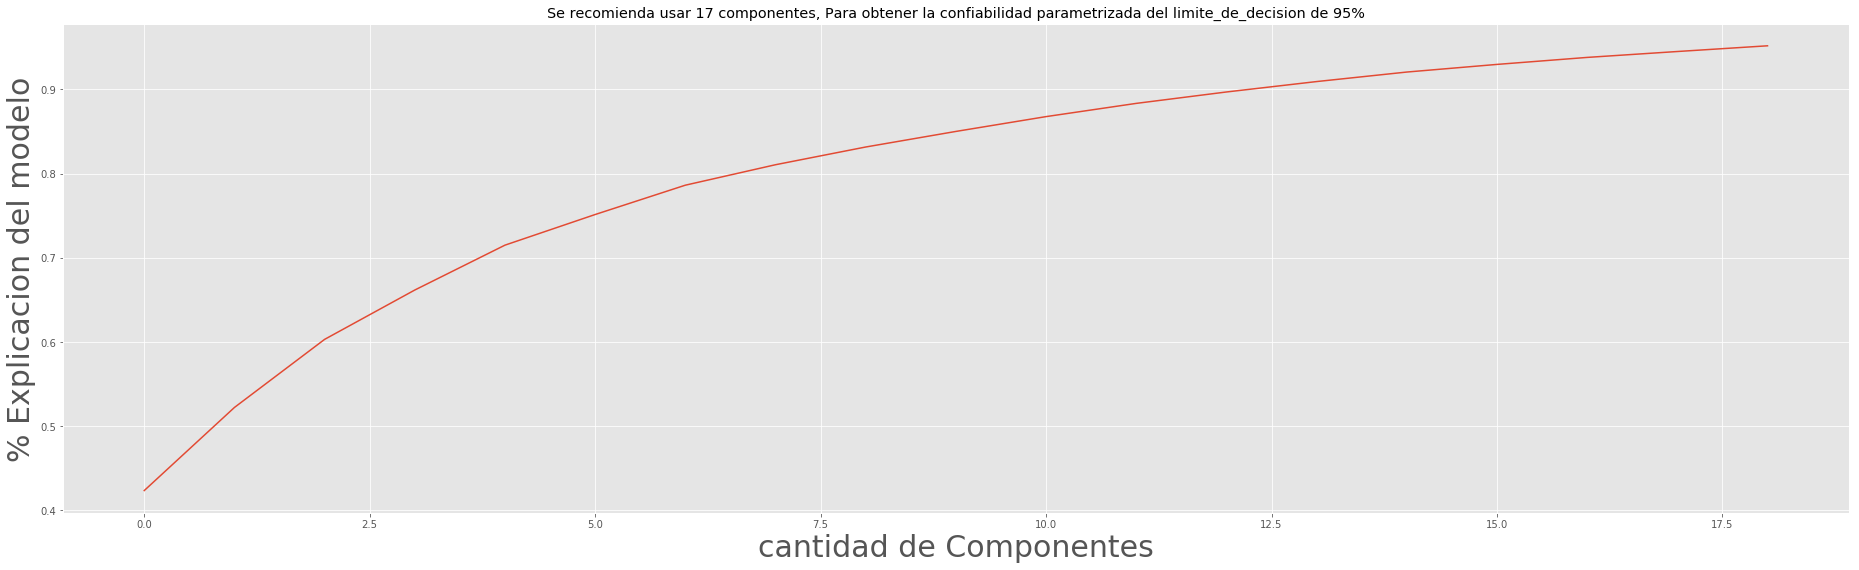

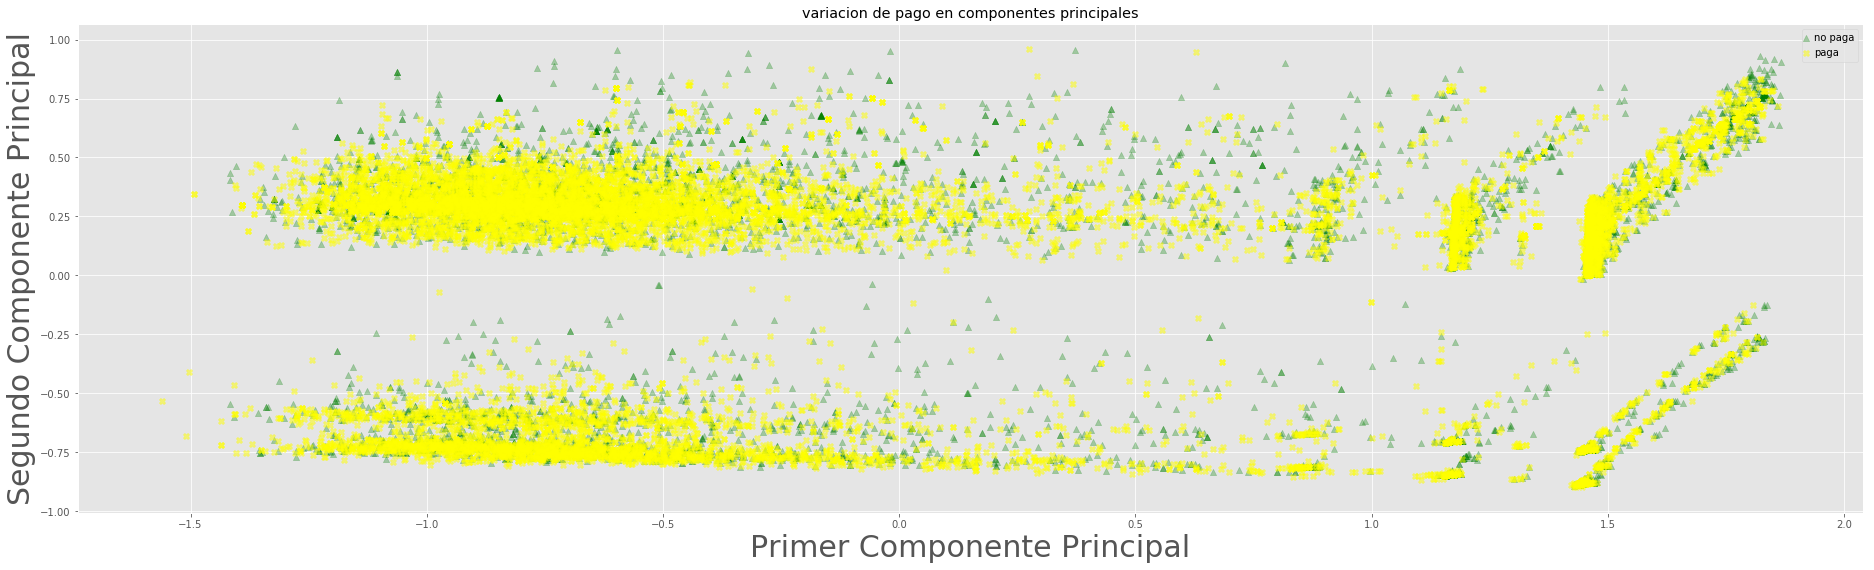

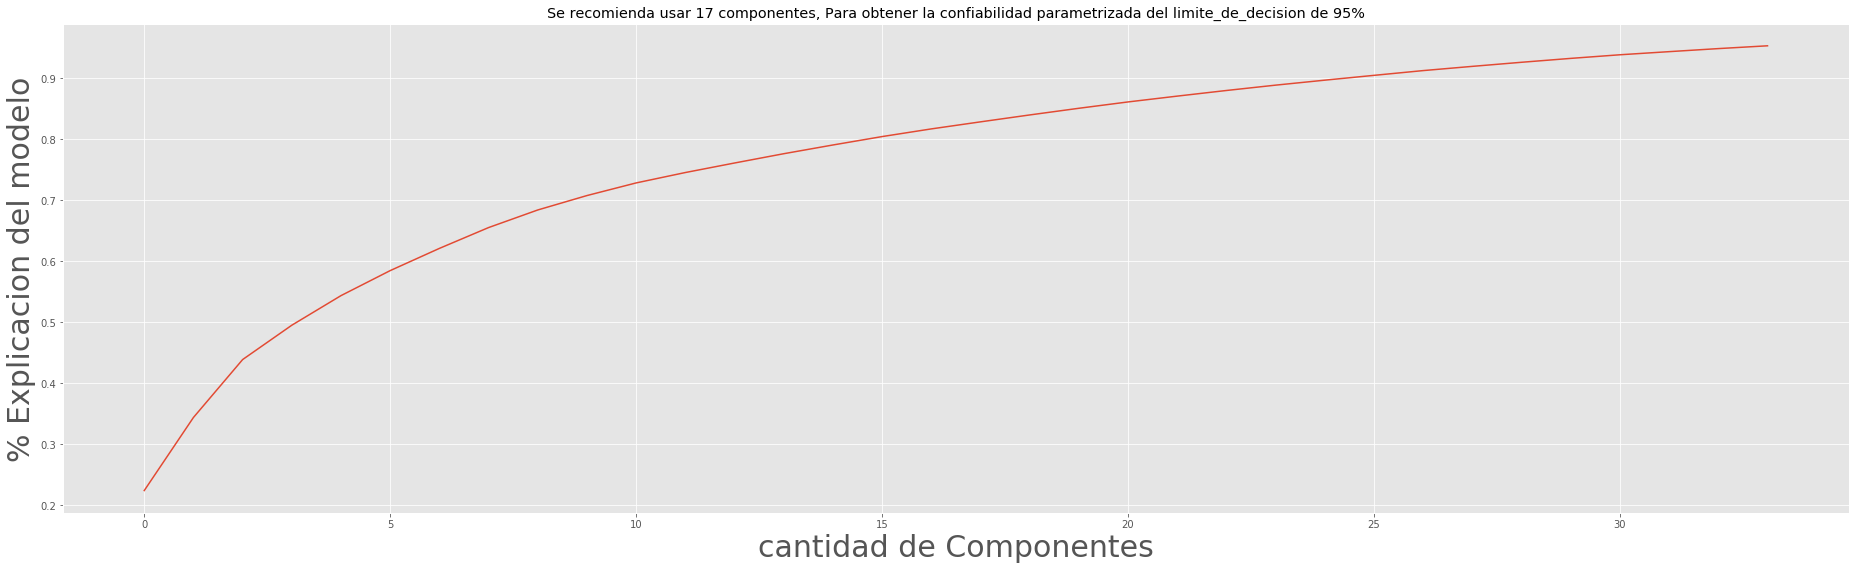

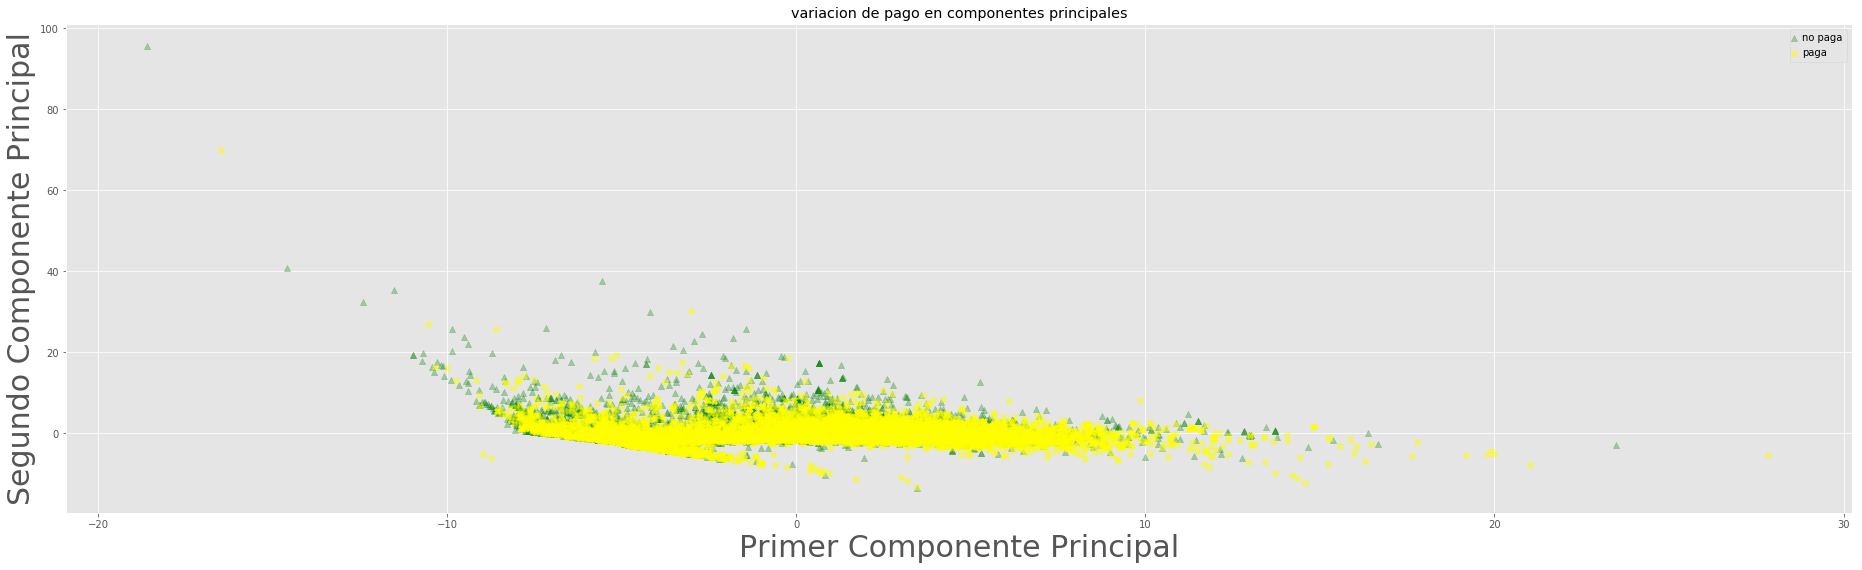

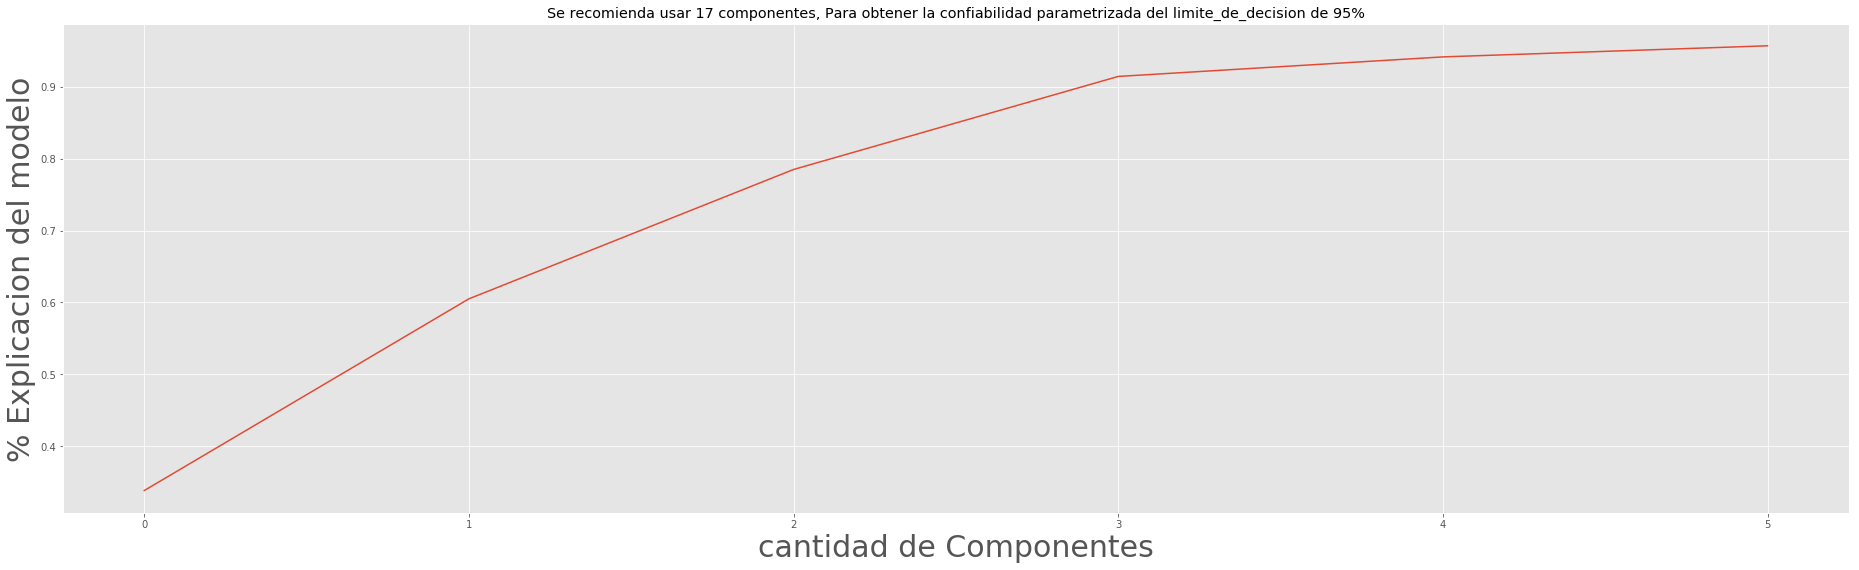

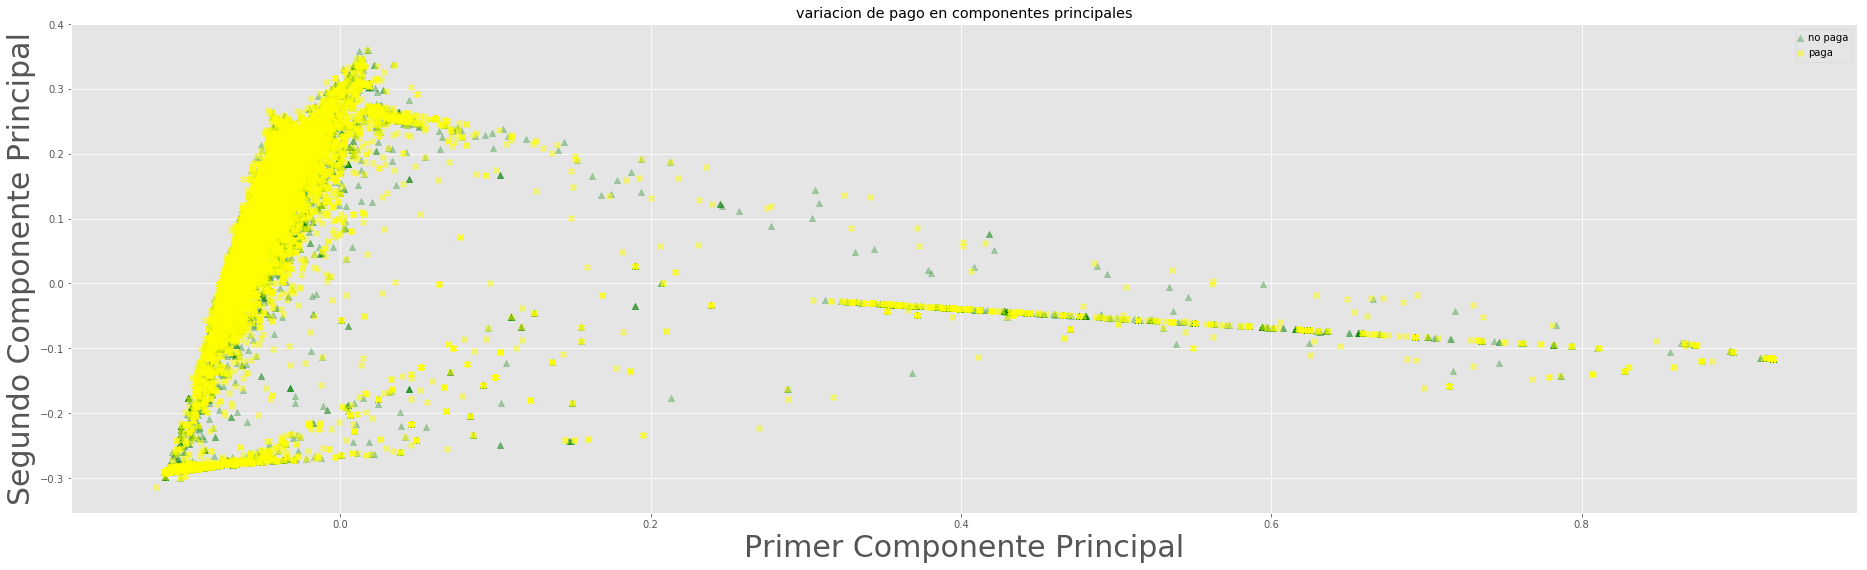

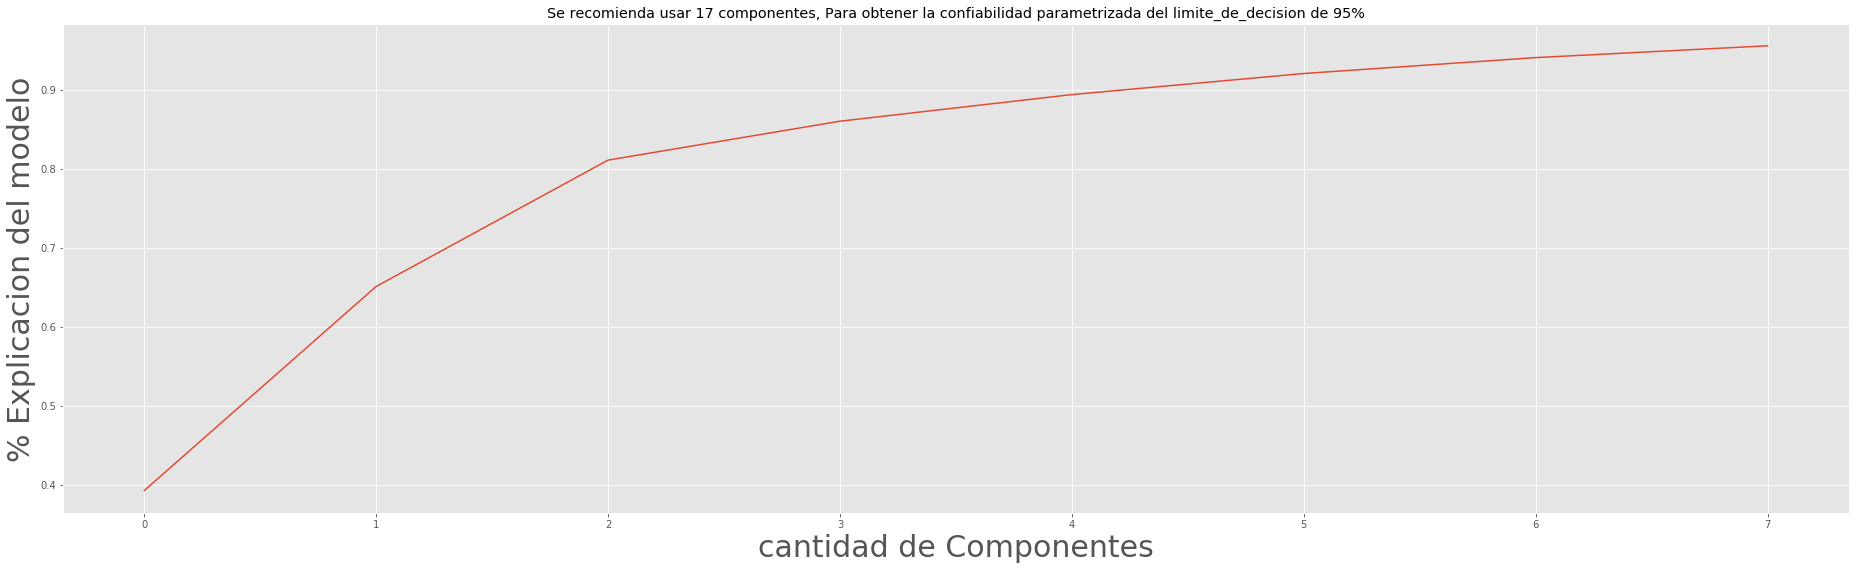

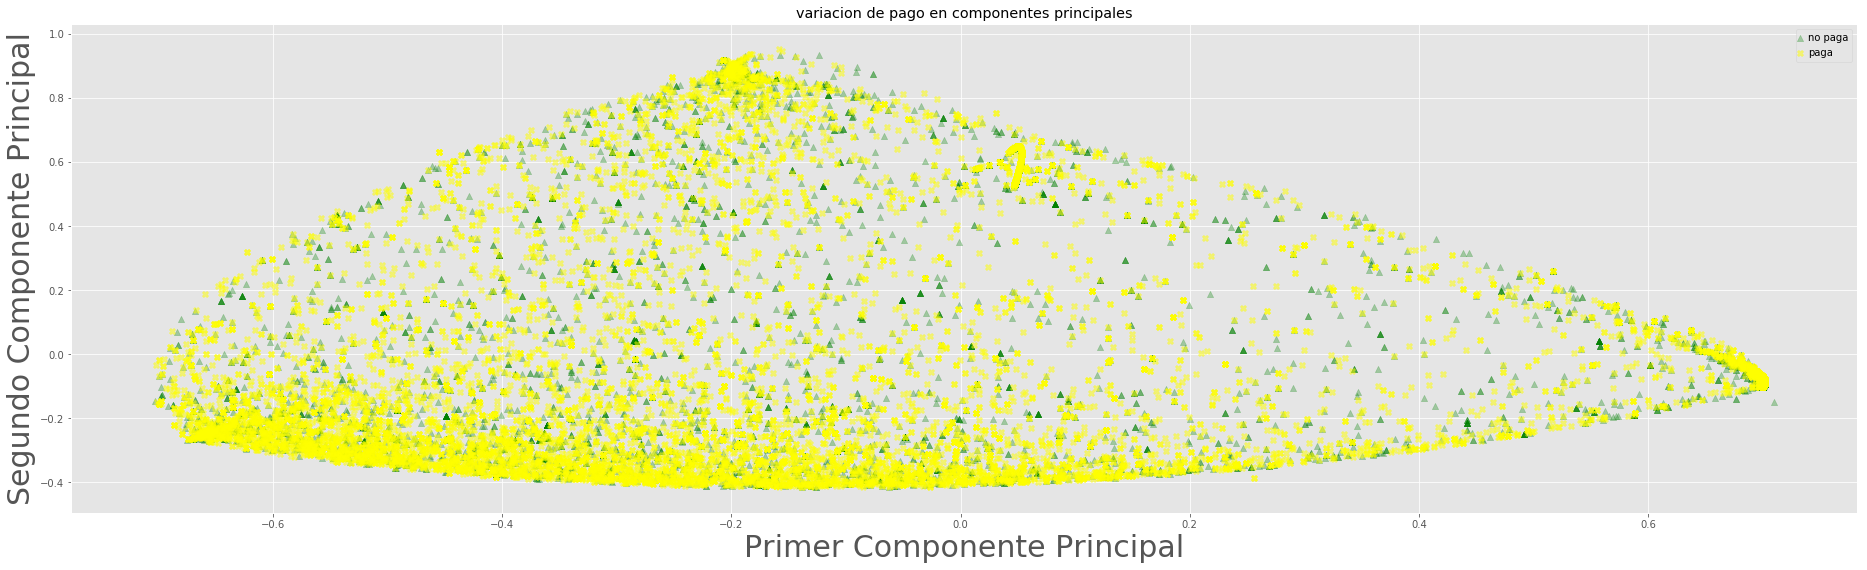

In [57]:
total_componentes_recomendados = graficar_componentes_reducidos(componentes_reducidos, valores_componentes_reducidos, df_redimensionado, variable_a_predecir)

In [58]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 68.901
El tiempo de ejecucion actual en minutos es: 1.148


# Crea el dataset con los componentes principales

In [59]:
dataset_recomendado_descendente = obtener_componentes_principales(df_redimensionado, variable_a_predecir, total_componentes_recomendados, 'descendente')
dataset_recomendado_ascendente  = obtener_componentes_principales(df_redimensionado, variable_a_predecir, total_componentes_recomendados, 'ascendente')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


In [60]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 69.43
El tiempo de ejecucion actual en minutos es: 1.157


# Correlacion de Caracteristicas de Pearson

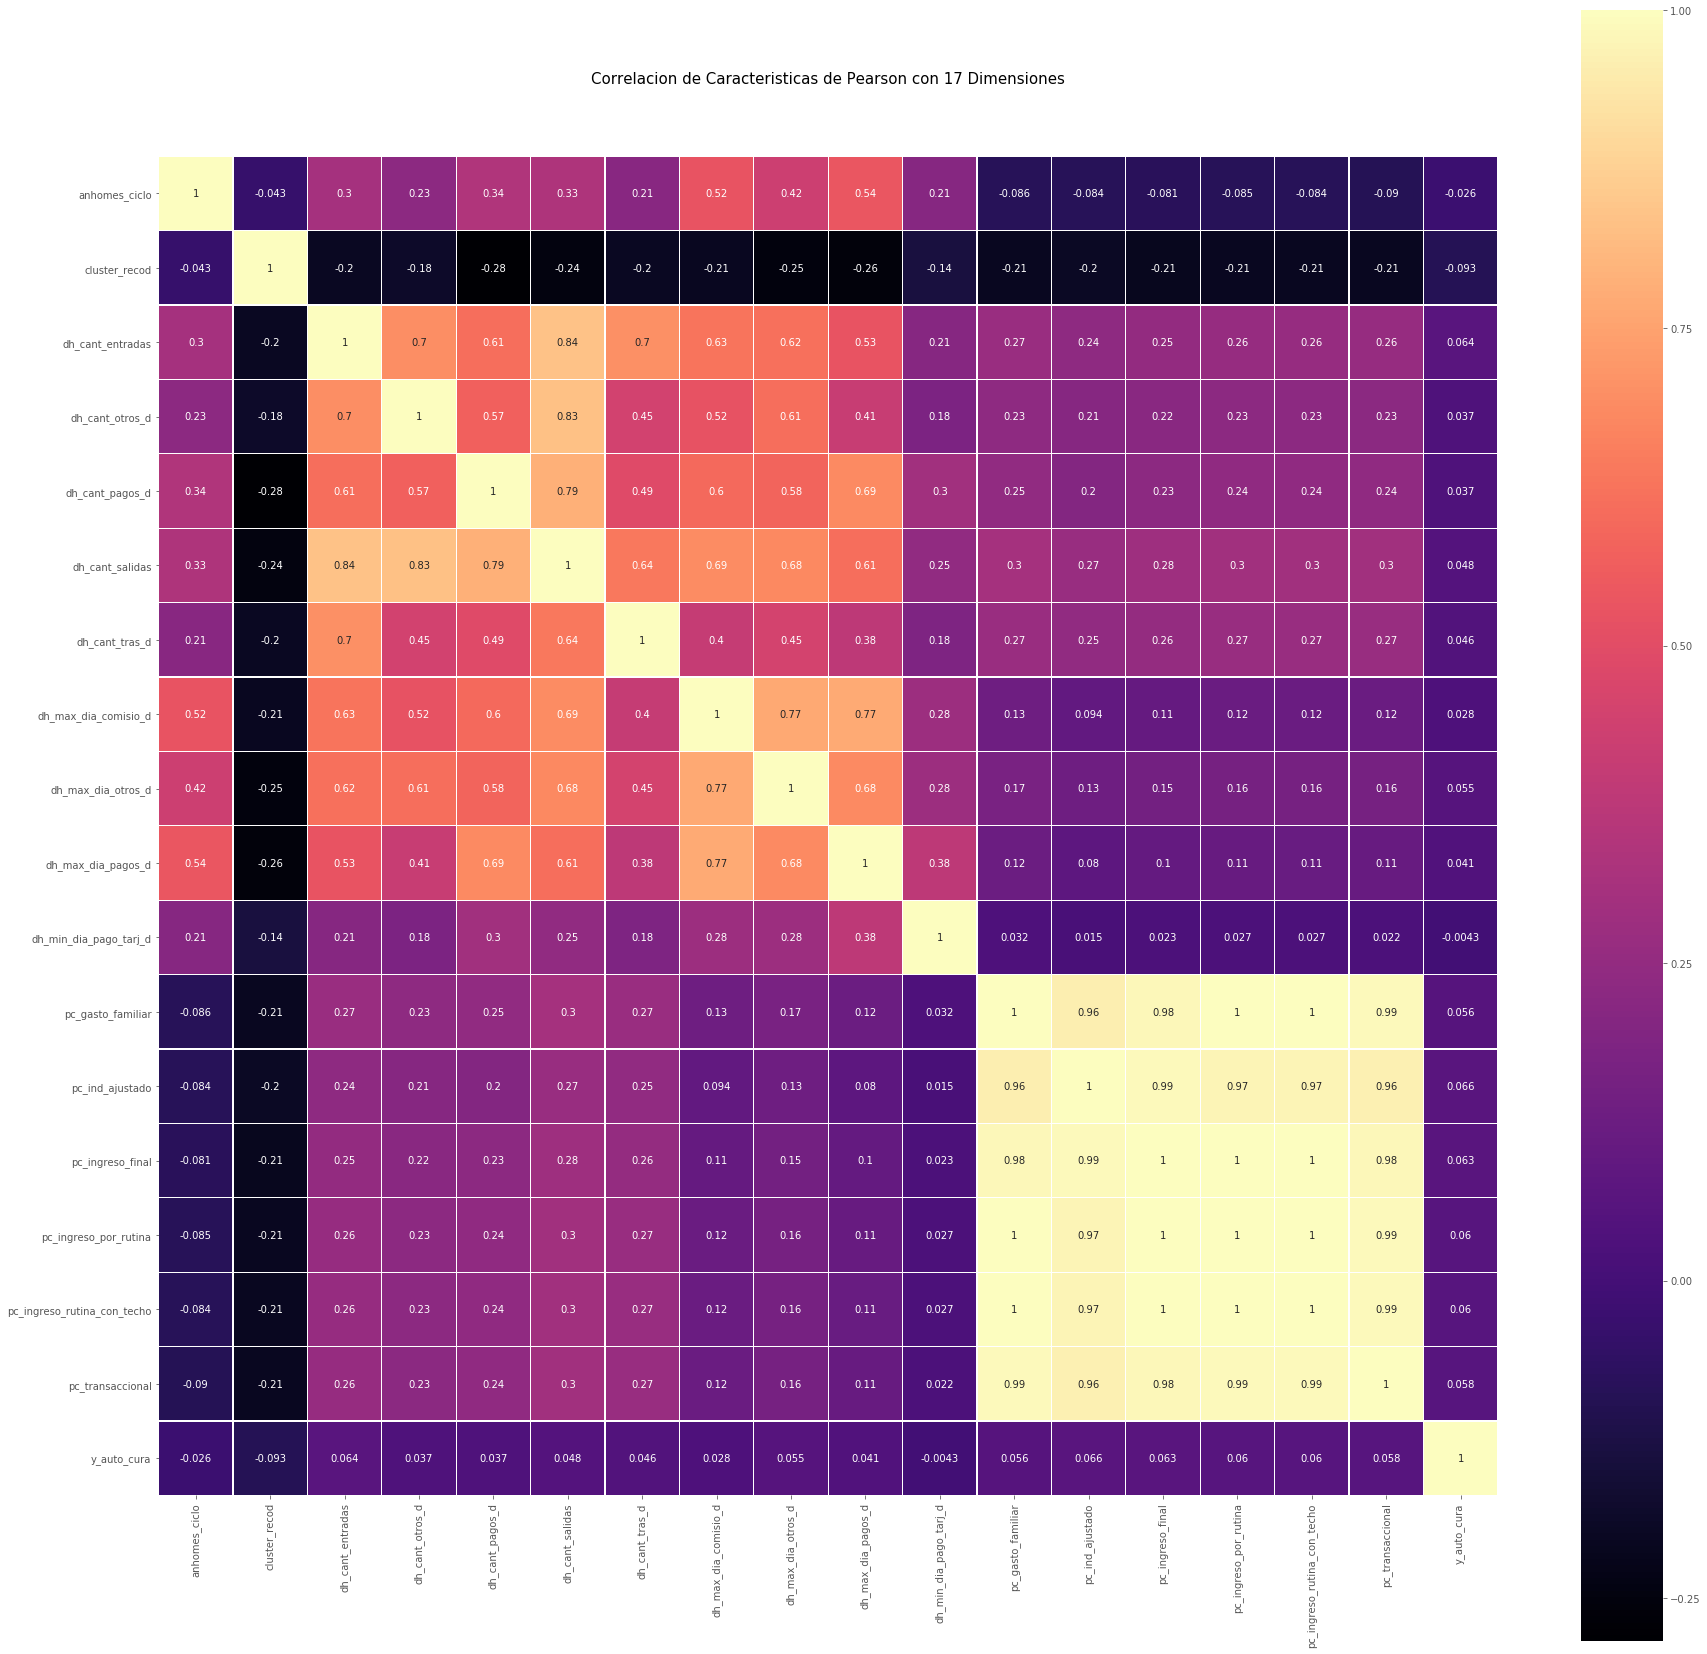

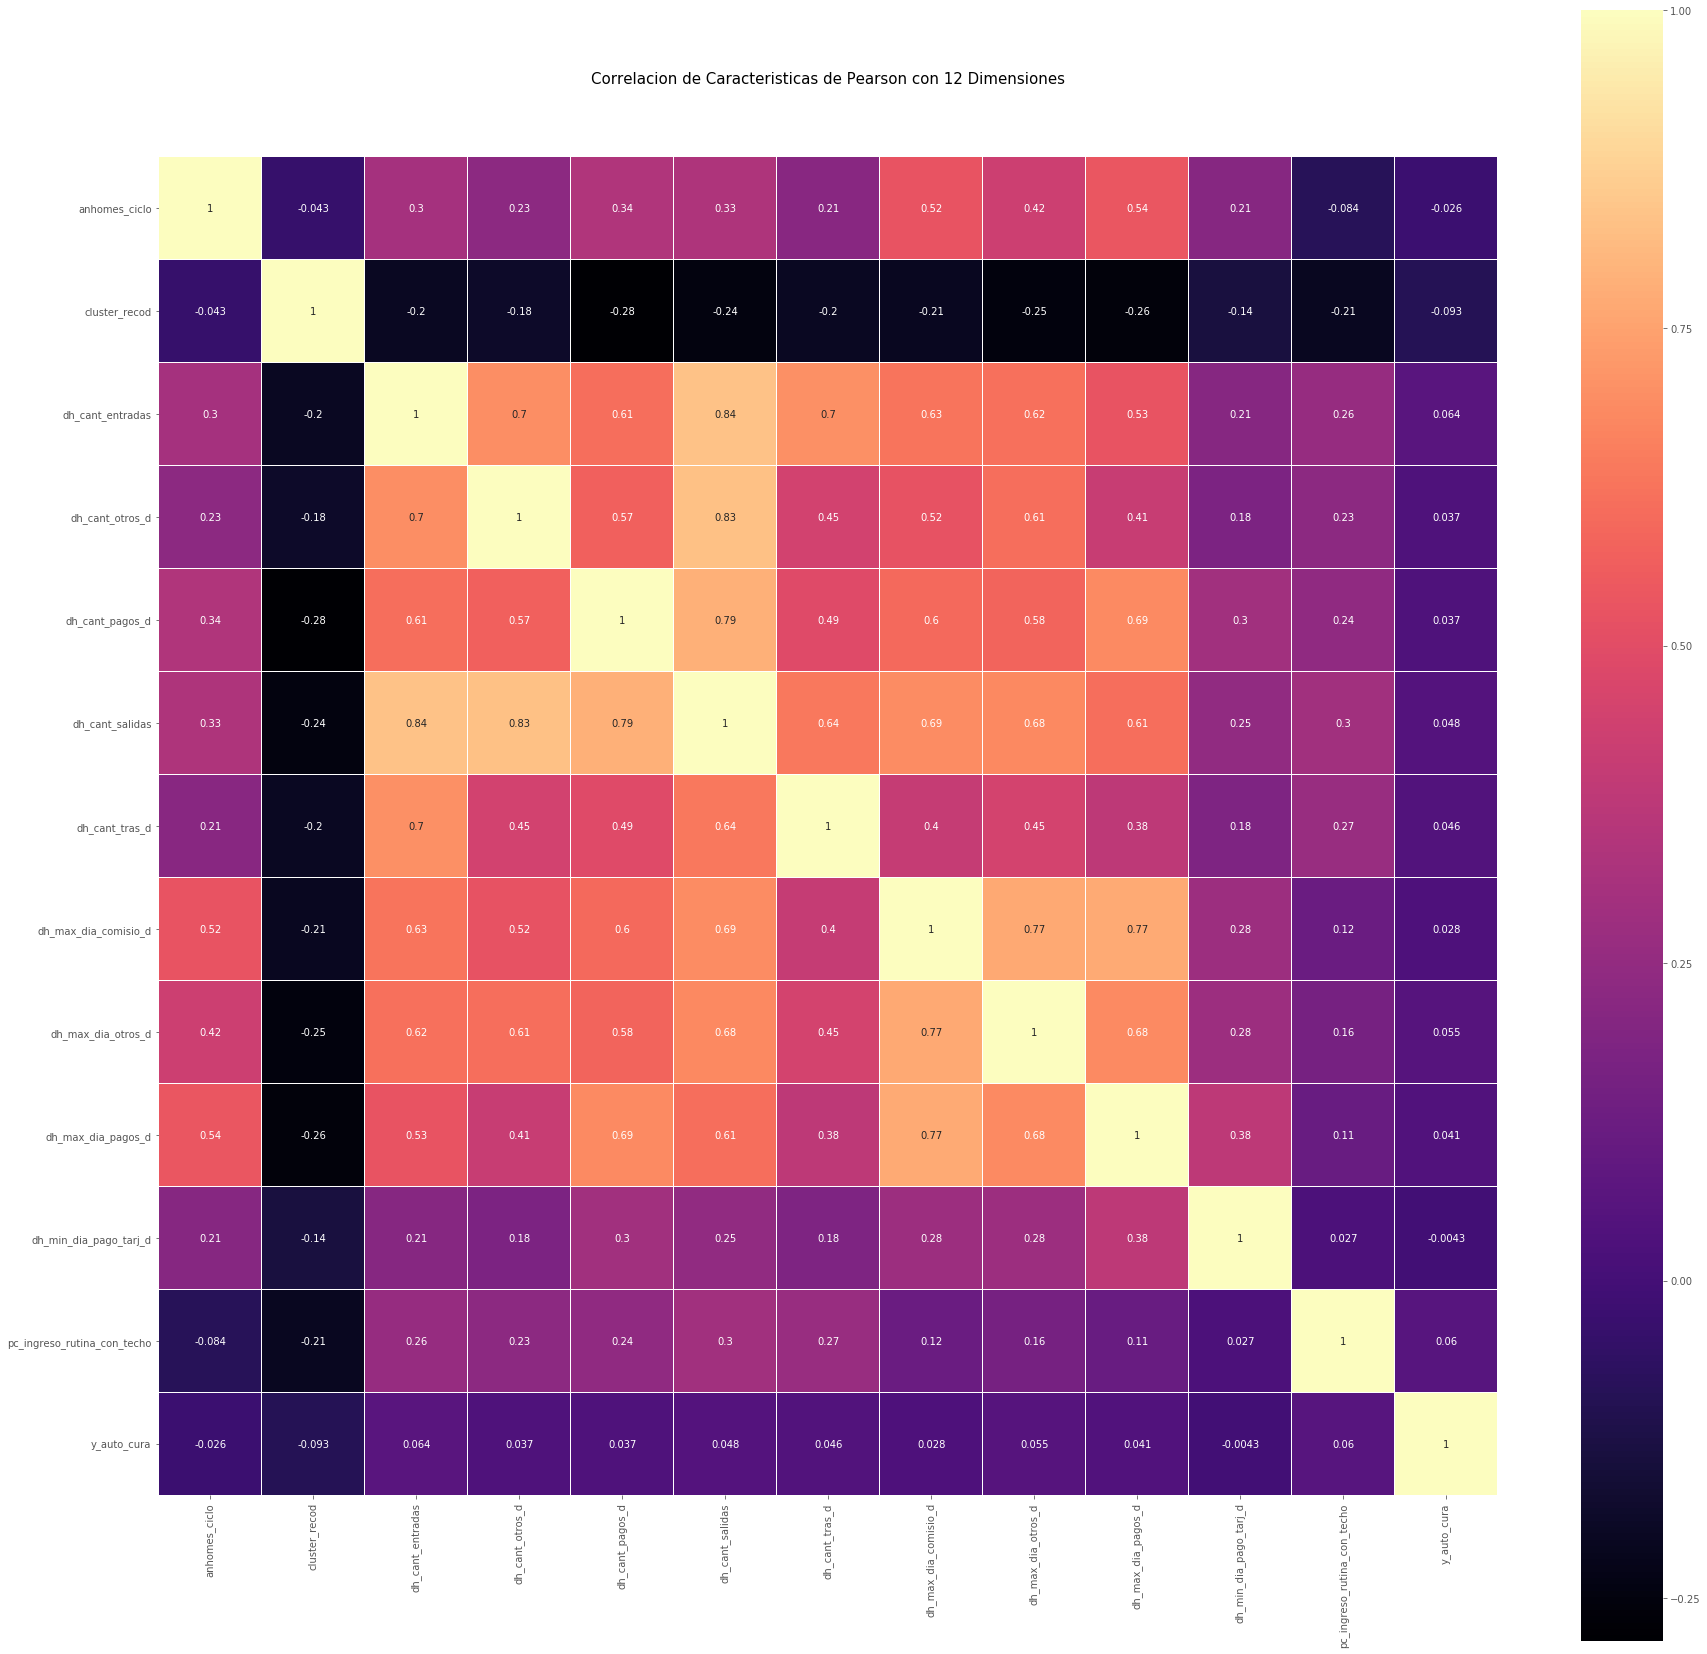

In [61]:
# obtiene el dataset corregido, eliminando las variables que son correlacionadas por encima del limite_de_decision
dataset_depurado = obtener_dataset_sin_correlacion (dataset_recomendado_descendente)

In [62]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 75.797
El tiempo de ejecucion actual en minutos es: 1.263


# Genera datasets para entrenamiento y validacion, con la finalidad de hacer verificacion con Matriz de Confusion y Curva ROC 

In [63]:
# obtengo los datasets de entrenamiento y validacion, para verificar si el ejercicio si esta dando una buena respuesta
# al utilizar los algoritmos en el modelo actual
dataset_entrenamiento, dataset_validacion = generar_datasets_entrenamiento_validacion(dataset_depurado,limite_de_decision)

In [64]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 75.823
El tiempo de ejecucion actual en minutos es: 1.264


# <center>7. ENTRENAMIENTO DEL MODELO Y ELECCIÓN DEL CLASIFICADOR </center>

# Crea el dataset para usar el clasificador

In [65]:
# obtiene el dataset en 2 conjuntos de datos, uno de entrenamiento y otro de prueba
conjunto_de_datos_para_clasificador = crear_conjunto_de_datos_para_clasificador (dataset_depurado, variable_a_predecir, tamano_conjunto_de_entrenamiento)

In [66]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 75.852
El tiempo de ejecucion actual en minutos es: 1.264


# obtiene la evaluacion de los clasificadores con roc auc, la matriz de confusion, el accuracy, recall, precision, f1-score, promedio cross validation.

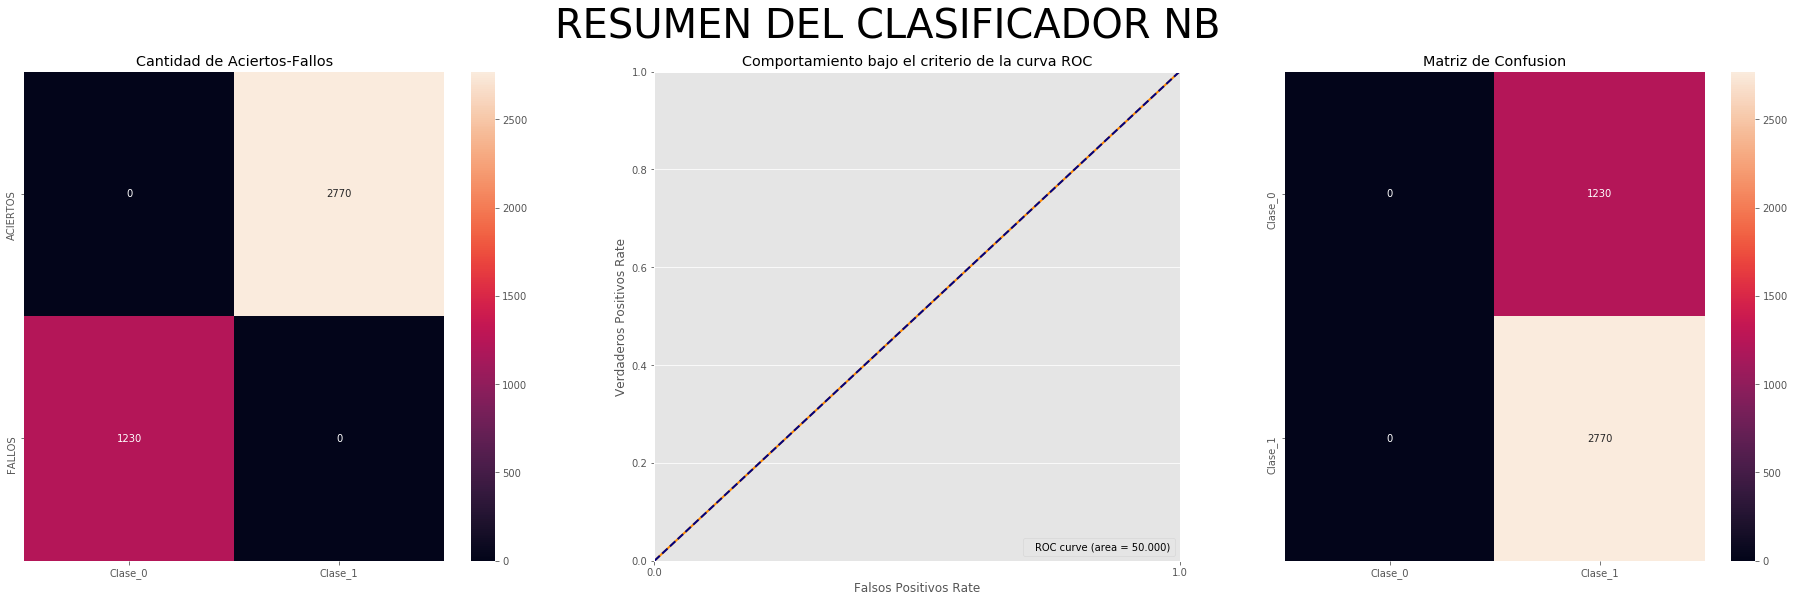

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  69.25 %
Precision:  69.25 %
Recall:  100.0 %
F1-Score:  81.832 %
Area Bajo la curva:  50.0 %
El promedio de Cross Validation para  10  validaciones es:  69.238 % con una variabilidad de +/-  0.017 %


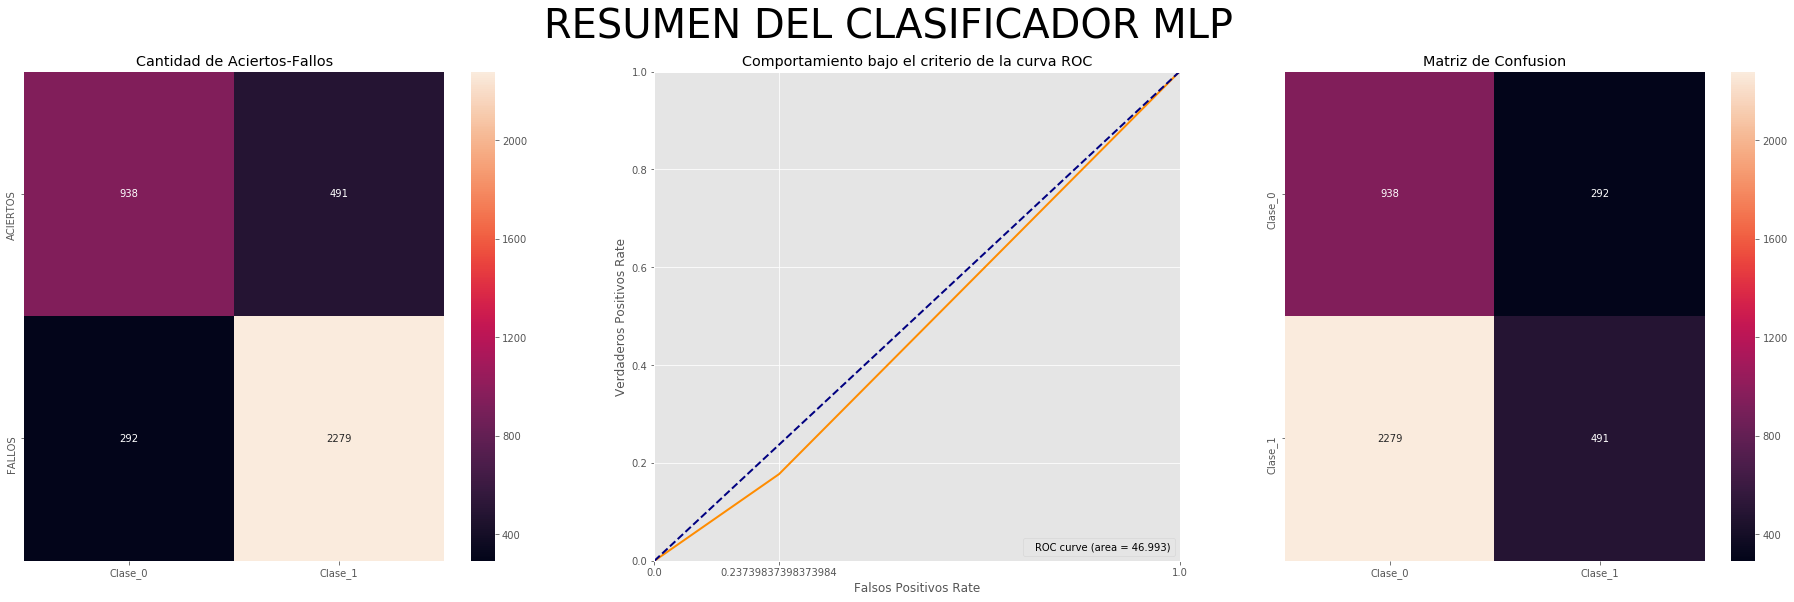

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  35.725 %
Precision:  62.708 %
Recall:  17.726 %
F1-Score:  27.639 %
Area Bajo la curva:  46.993 %
El promedio de Cross Validation para  10  validaciones es:  35.619 % con una variabilidad de +/-  0.408 %


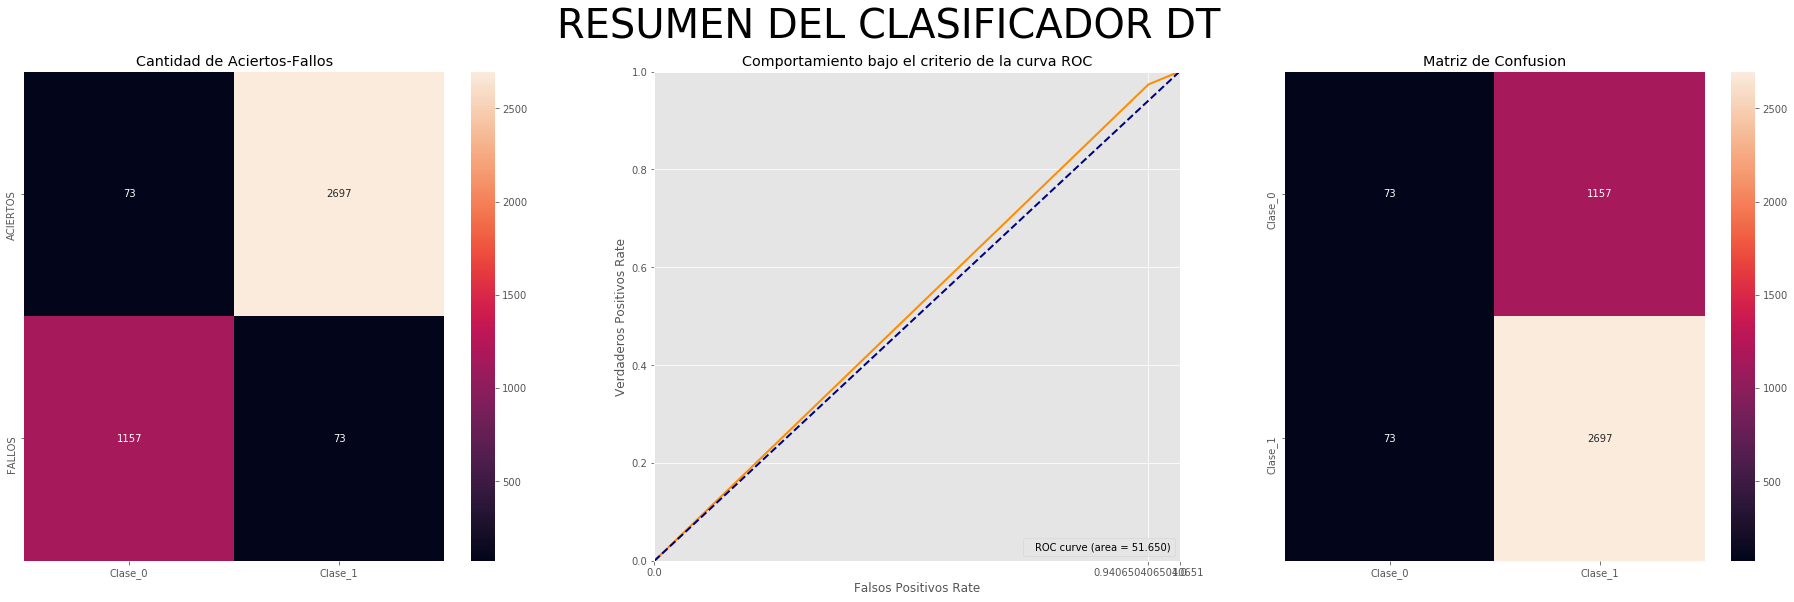

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  69.25 %
Precision:  69.979 %
Recall:  97.365 %
F1-Score:  81.431 %
Area Bajo la curva:  51.65 %
El promedio de Cross Validation para  10  validaciones es:  69.644 % con una variabilidad de +/-  0.222 %


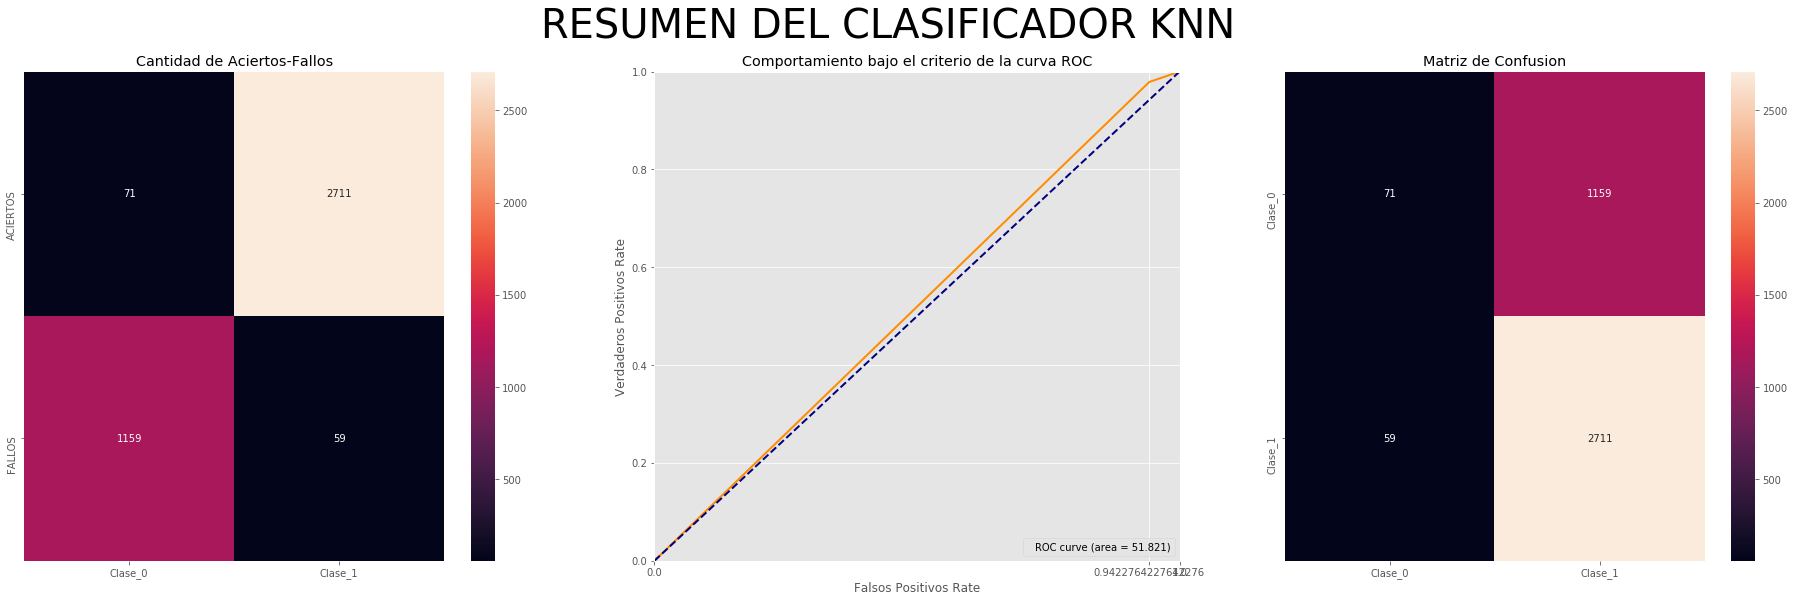

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  69.55 %
Precision:  70.052 %
Recall:  97.87 %
F1-Score:  81.657 %
Area Bajo la curva:  51.821 %
El promedio de Cross Validation para  10  validaciones es:  69.563 % con una variabilidad de +/-  0.414 %


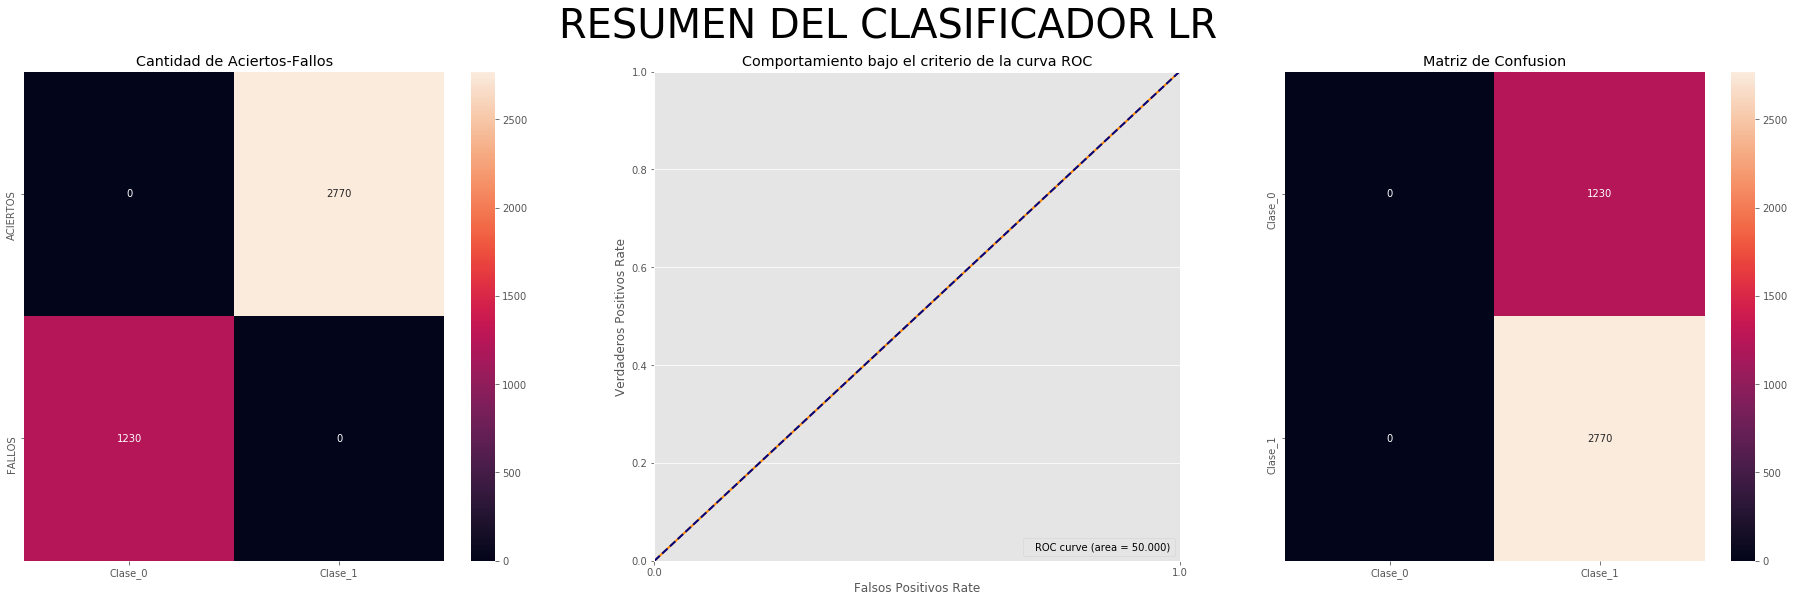

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  69.25 %
Precision:  69.25 %
Recall:  100.0 %
F1-Score:  81.832 %
Area Bajo la curva:  50.0 %
El promedio de Cross Validation para  10  validaciones es:  69.238 % con una variabilidad de +/-  0.017 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramDa

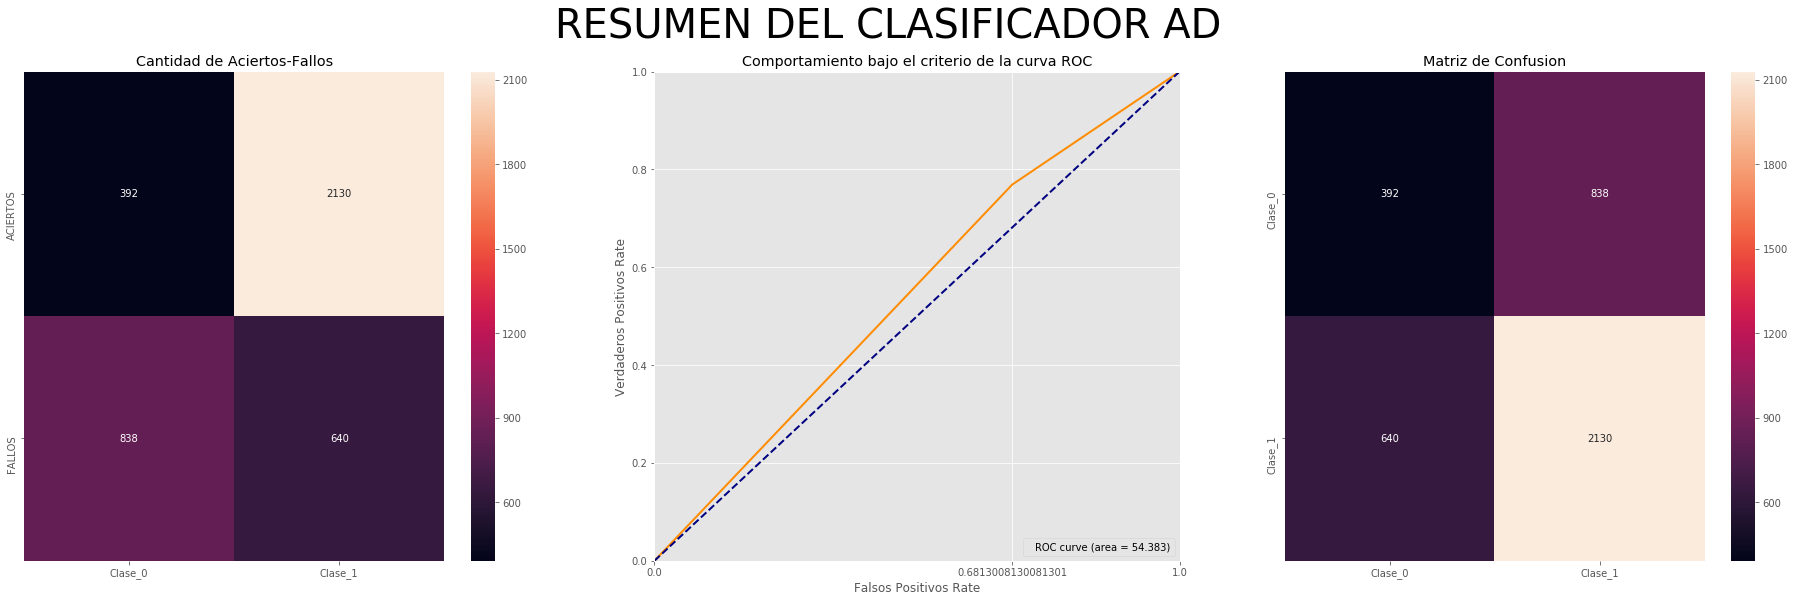

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  63.05 %
Precision:  71.765 %
Recall:  76.895 %
F1-Score:  74.242 %
Area Bajo la curva:  54.383 %
El promedio de Cross Validation para  10  validaciones es:  69.244 % con una variabilidad de +/-  0.028 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Se

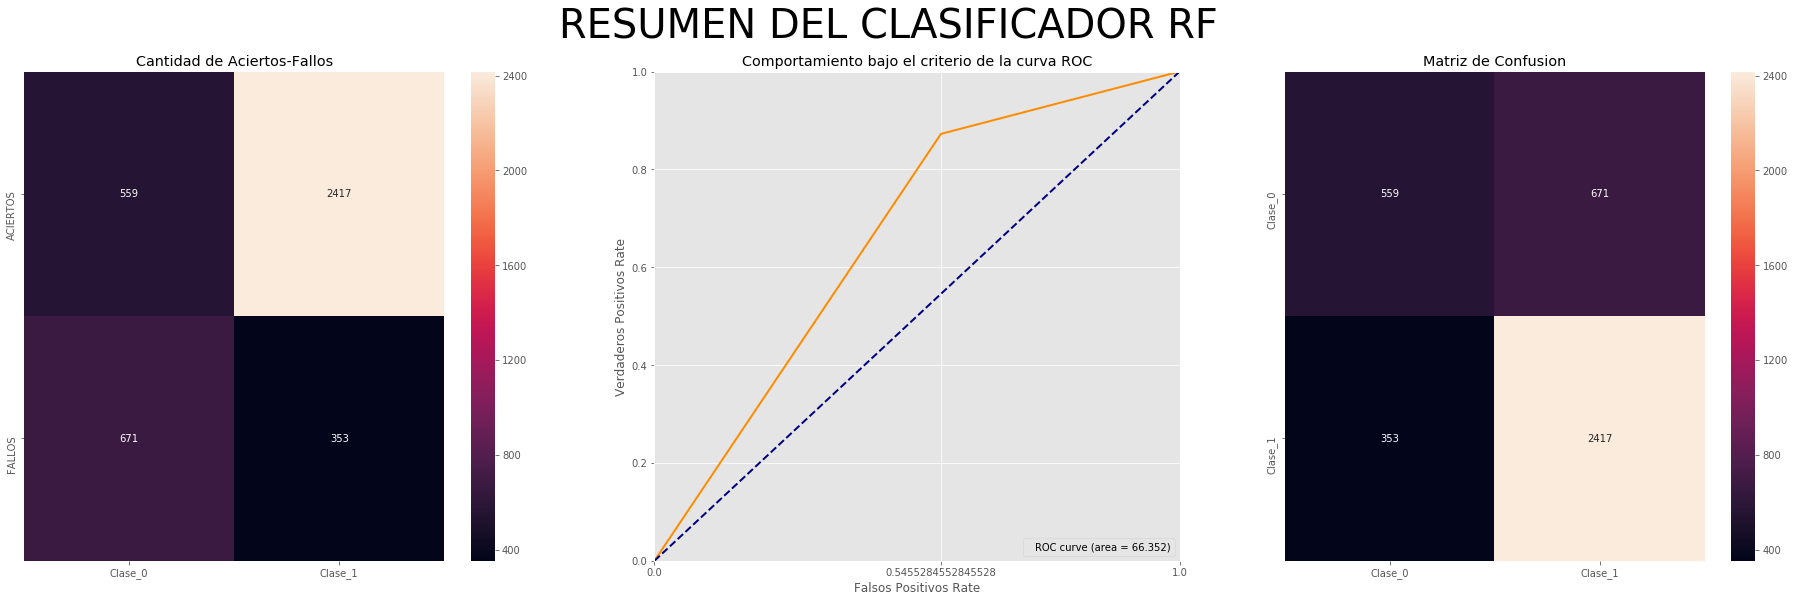

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  74.4 %
Precision:  78.271 %
Recall:  87.256 %
F1-Score:  82.52 %
Area Bajo la curva:  66.352 %
El promedio de Cross Validation para  10  validaciones es:  73.744 % con una variabilidad de +/-  0.831 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Se

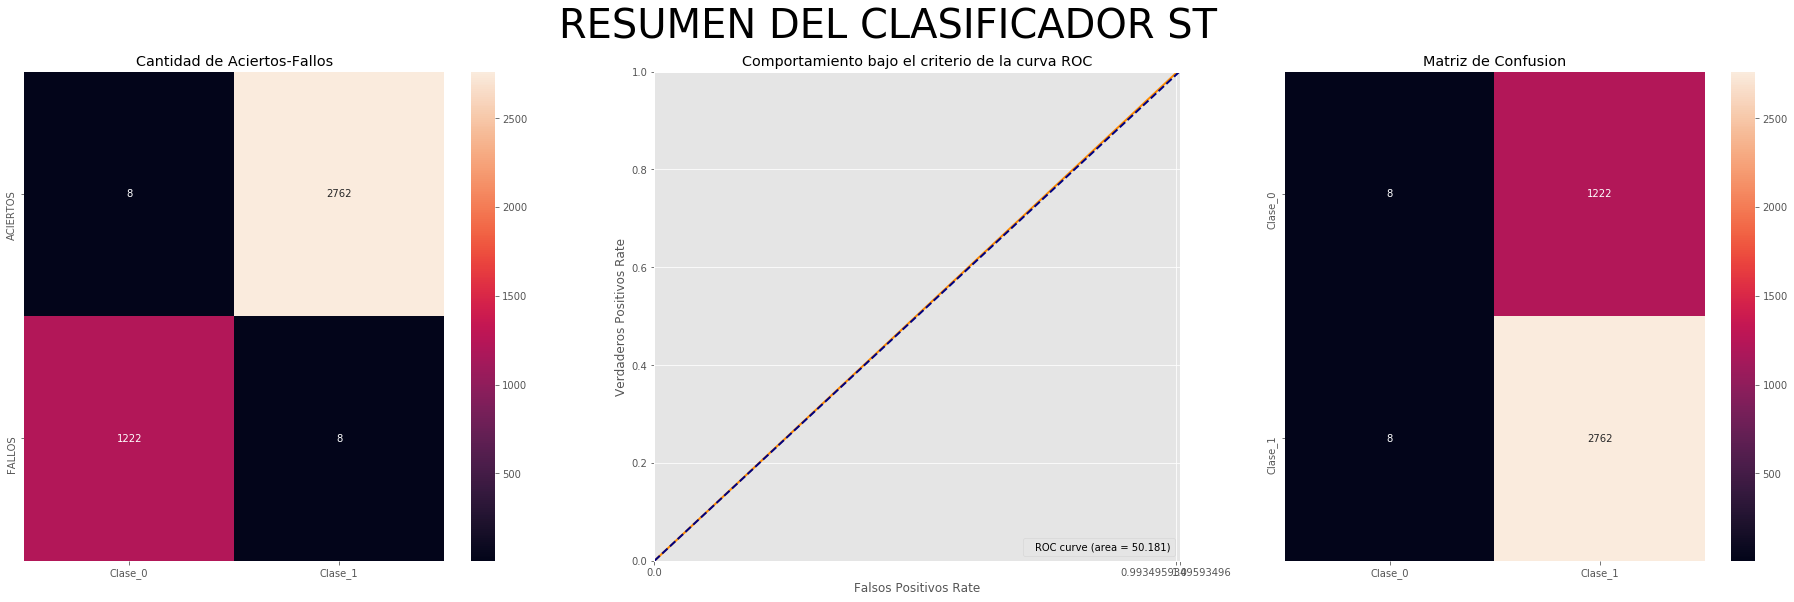

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  69.25 %
Precision:  69.327 %
Recall:  99.711 %
F1-Score:  81.789 %
Area Bajo la curva:  50.181 %
El promedio de Cross Validation para  10  validaciones es:  69.244 % con una variabilidad de +/-  0.028 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramDa

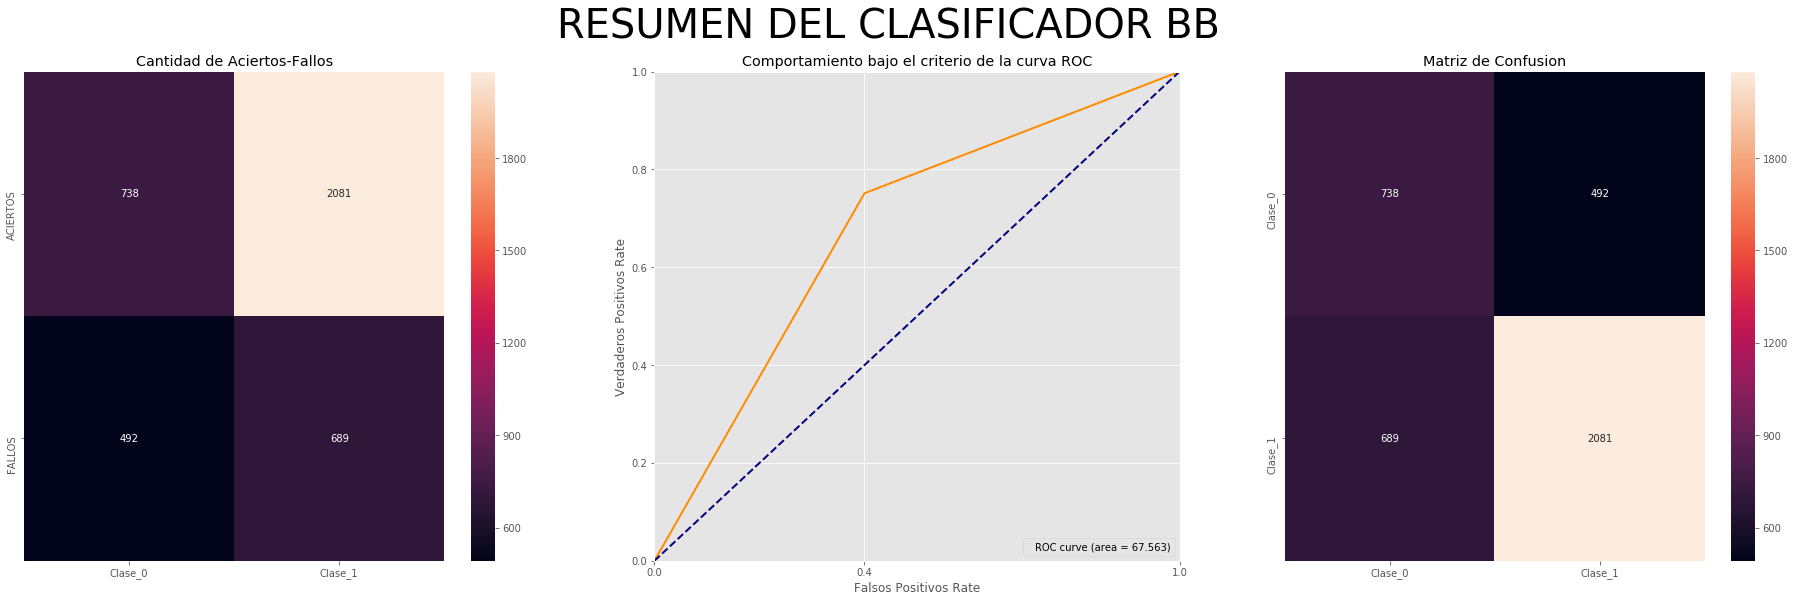

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  70.475 %
Precision:  80.878 %
Recall:  75.126 %
F1-Score:  77.896 %
Area Bajo la curva:  67.563 %
El promedio de Cross Validation para  10  validaciones es:  70.563 % con una variabilidad de +/-  0.764 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


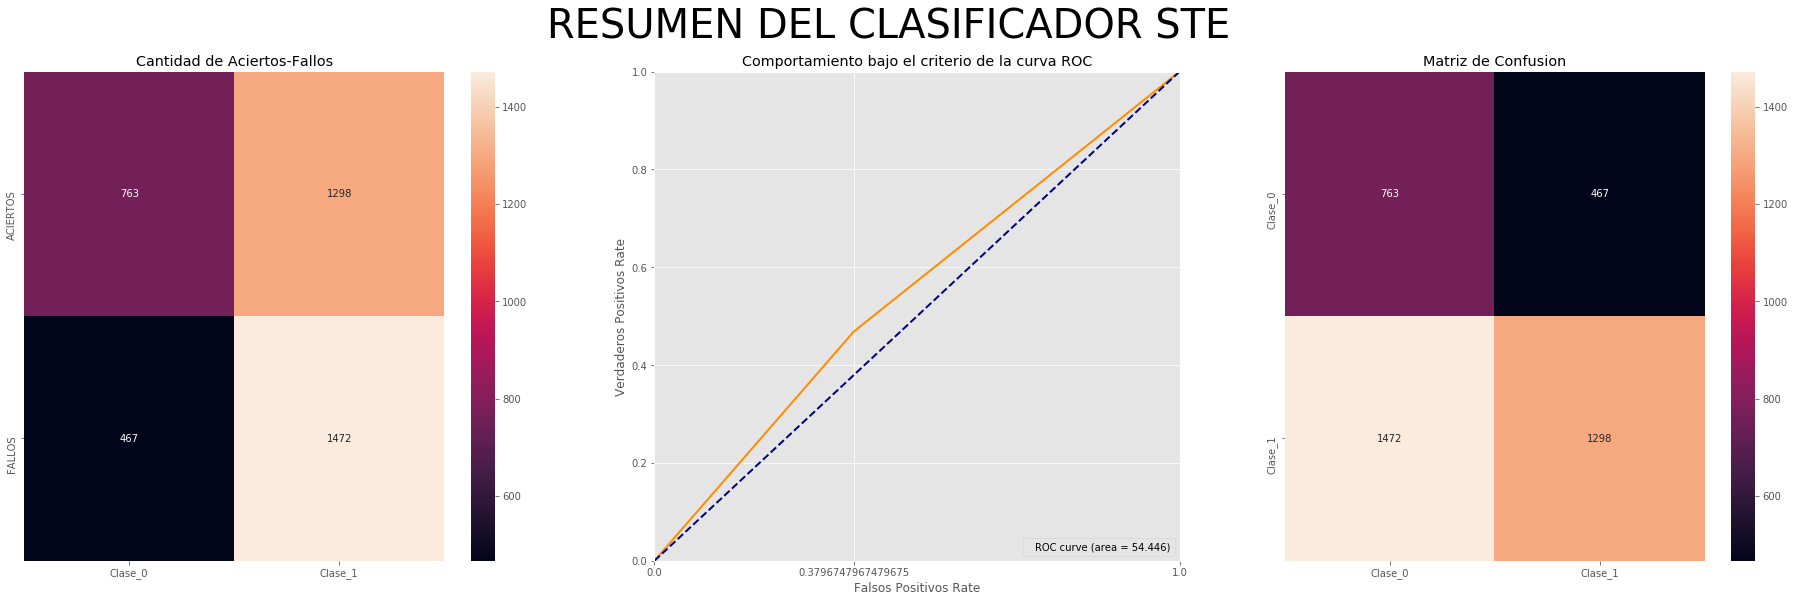

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  51.525 %
Precision:  73.541 %
Recall:  46.859 %
F1-Score:  57.244 %
Area Bajo la curva:  54.446 %
El promedio de Cross Validation para  10  validaciones es:  69.244 % con una variabilidad de +/-  0.028 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: 

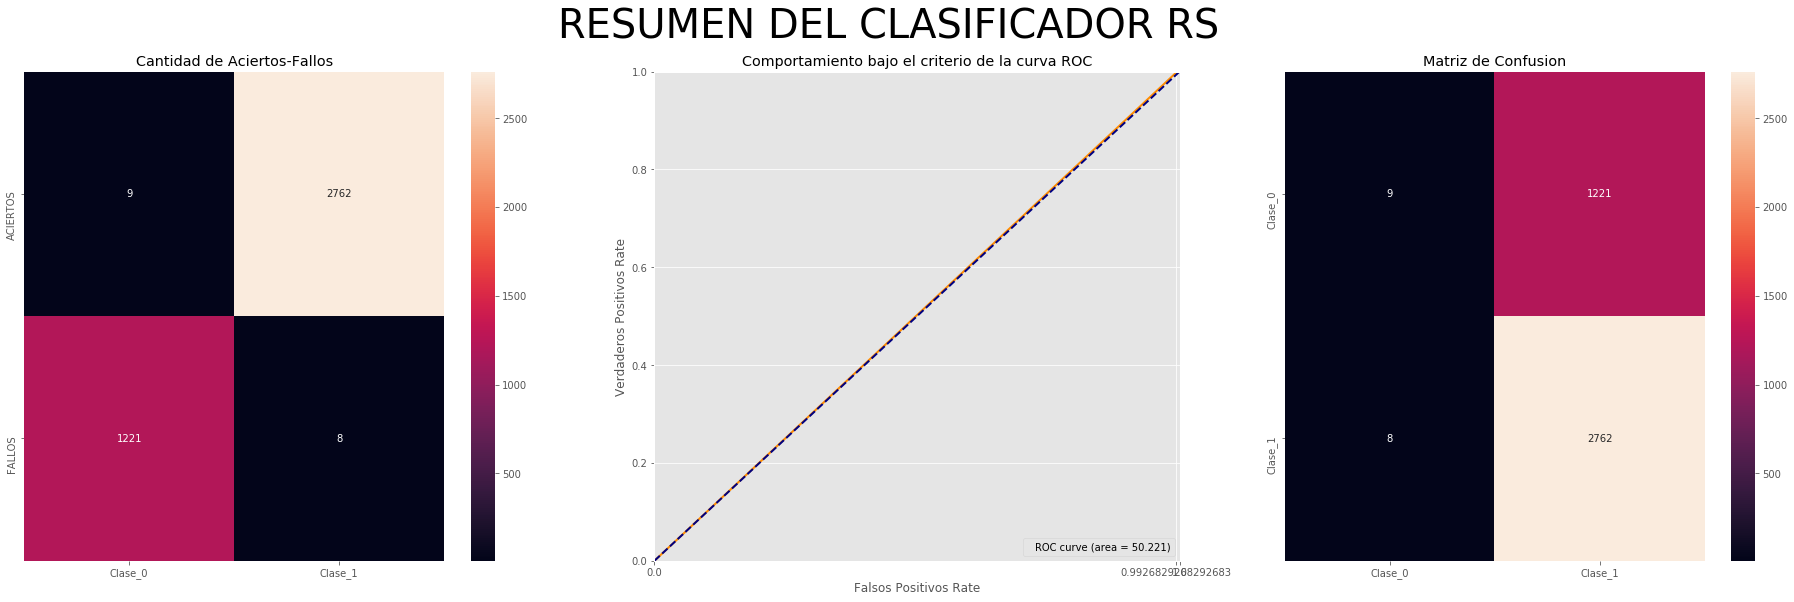

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  69.275 %
Precision:  69.345 %
Recall:  99.711 %
F1-Score:  81.801 %
Area Bajo la curva:  50.221 %
El promedio de Cross Validation para  10  validaciones es:  69.244 % con una variabilidad de +/-  0.028 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: 

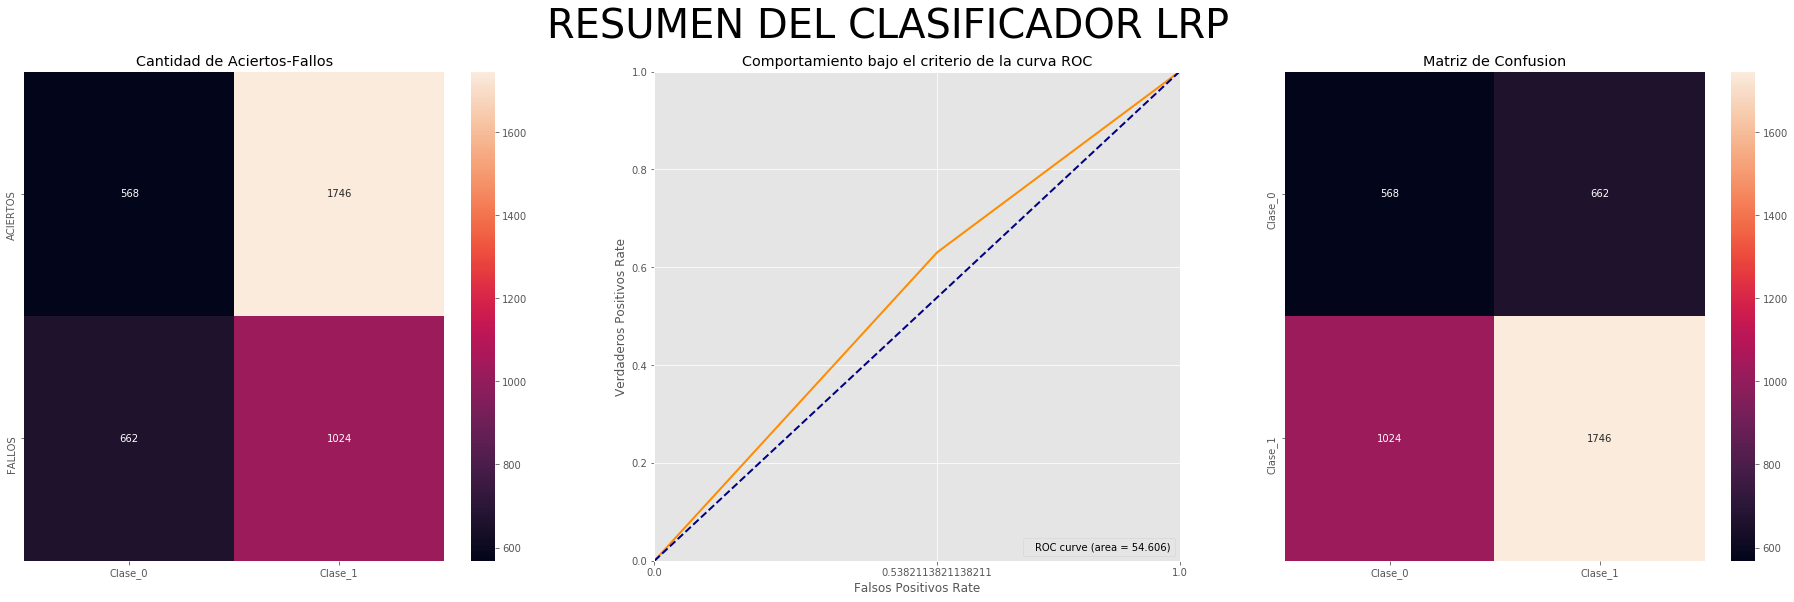

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  57.85 %
Precision:  72.508 %
Recall:  63.032 %
F1-Score:  67.439 %
Area Bajo la curva:  54.606 %
El promedio de Cross Validation para  10  validaciones es:  58.081 % con una variabilidad de +/-  1.236 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


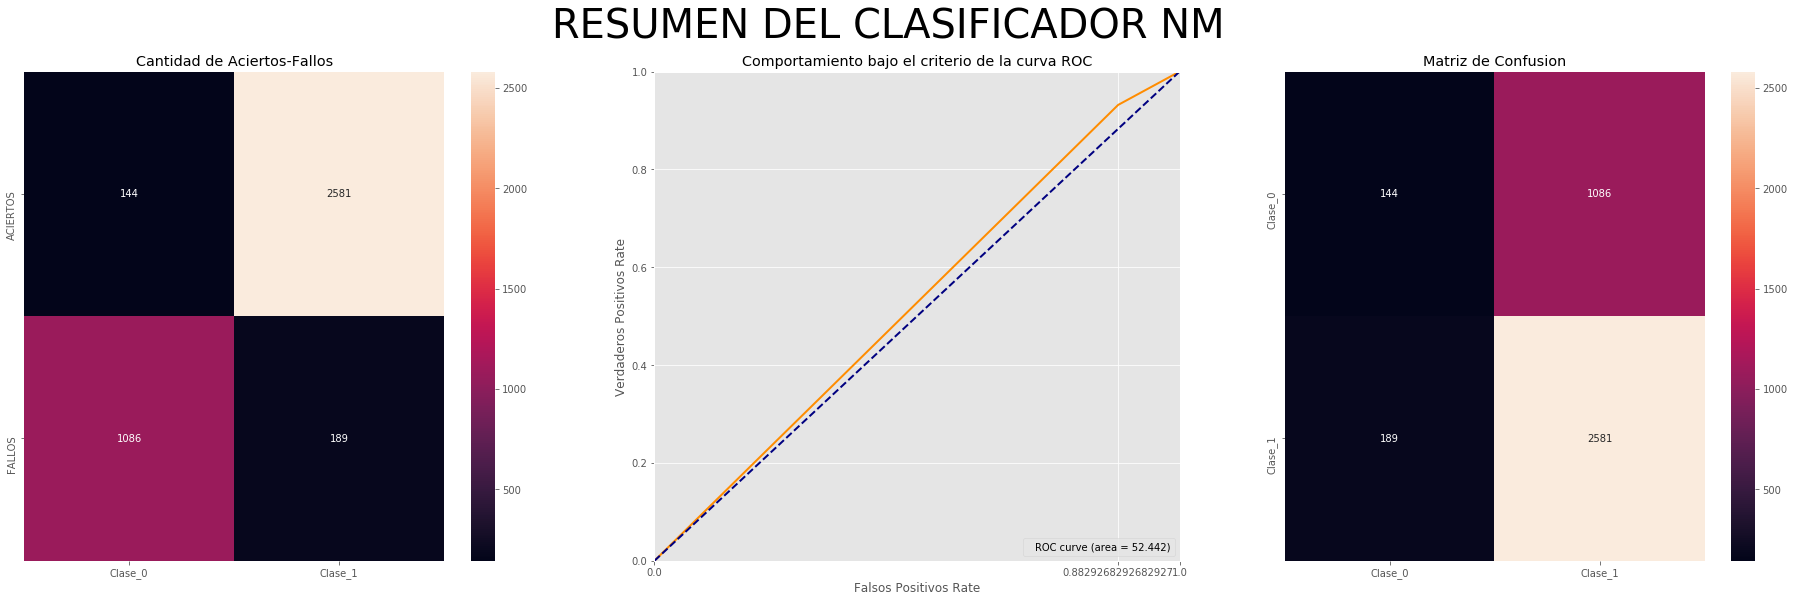

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  68.125 %
Precision:  70.385 %
Recall:  93.177 %
F1-Score:  80.193 %
Area Bajo la curva:  52.442 %
El promedio de Cross Validation para  10  validaciones es:  69.244 % con una variabilidad de +/-  0.028 %


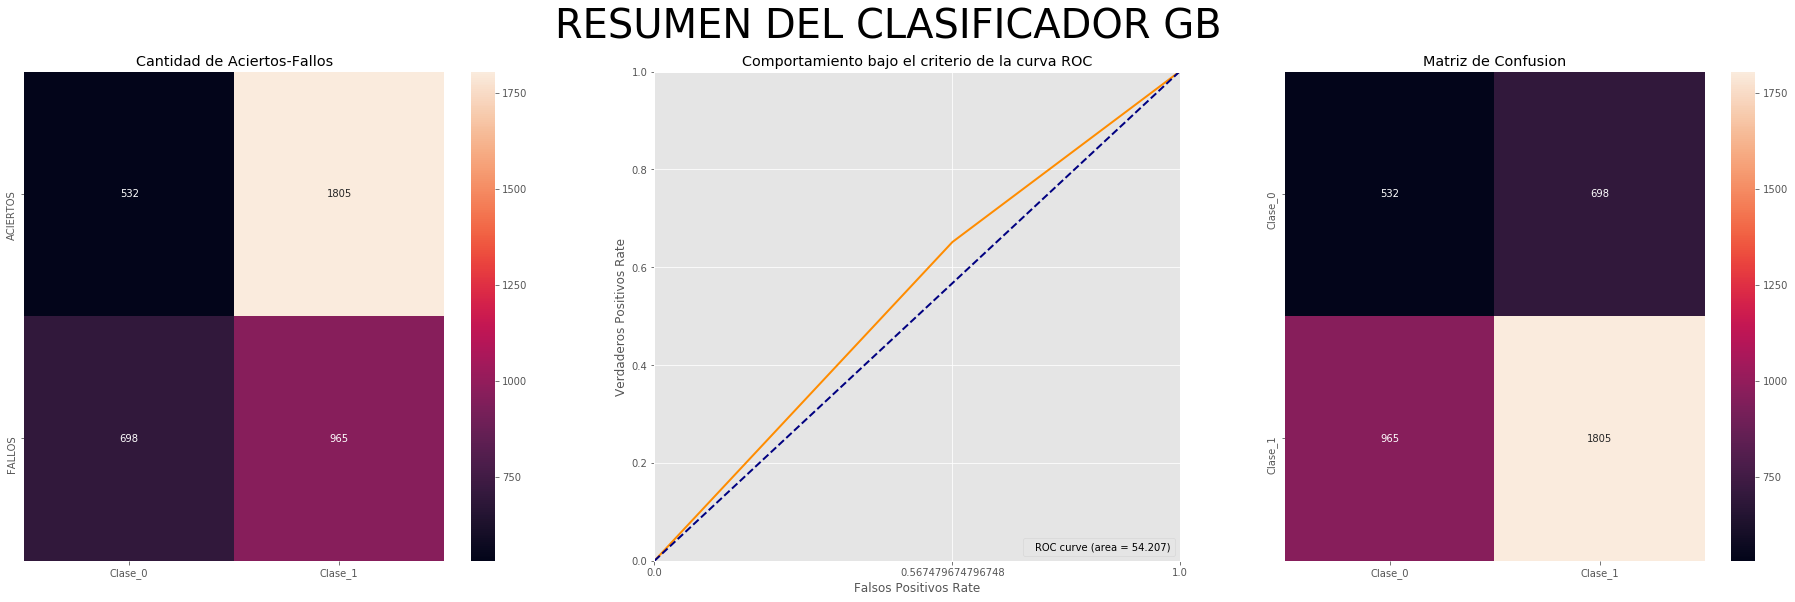

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

Accuracy:  58.425 %
Precision:  72.113 %
Recall:  65.162 %
F1-Score:  68.462 %
Area Bajo la curva:  54.207 %
El promedio de Cross Validation para  10  validaciones es:  56.981 % con una variabilidad de +/-  3.059 %


In [67]:
tabla_ordenada_de_clasificadores , mejor_clasificador, prediccion_mejor_clasificador = evaluar_y_elegir_mejor_clasificador(clasificadores, conjunto_de_datos_para_clasificador, precision, columnas_esperadas_del_clasificador, criterio_de_clasificador, tolerancia_de_decision, LABELS, limite_de_decision)

In [68]:
tabla_ordenada_de_clasificadores

,clasificador,area_bajo_la_curva,promedio_de_validez,promedio_validacion_cruzada,Clase_0,Clase_1
1,BB,67.563,67.563,70.563,60.000,75.126
2,RF,66.352,56.352,73.744,45.447,87.256
3,LRP,54.606,44.606,58.081,46.179,63.032
4,STE,54.446,44.446,69.244,62.033,46.859
5,GB,54.207,44.207,56.981,43.252,65.162
6,AD,54.383,39.383,69.244,31.870,76.895
7,NM,52.442,27.442,69.244,11.707,93.177
8,MLP,46.993,21.993,35.619,76.260,17.726
9,KNN,51.821,21.821,69.563,5.772,97.870
10,DT,51.650,21.650,69.644,5.935,97.365


# Muestra cual fue el mejor clasificador de los evaluados

In [69]:
# define cuantos clasificadores se quieren tener en cuenta para comparar sus resultados de prediccion en el analisis posterior
mejor_clasificador

['RF', 'BB']

In [70]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 1027.857
El tiempo de ejecucion actual en minutos es: 17.131


# <center>8. PREDICCIÓN DEL MODELO CON DATA CONOCIDA </center>

In [71]:
# verifico que tambien se porta el modelo con datos que conozco
# crea el nuevo dataset que contiene solo las variables que se obtuvieron al reducir el dataset
df_analisis_prediccion_conocida = dataset_validacion.drop(columns = list(set(list(dataset_validacion.columns)) - set(list(dataset_recomendado_descendente.drop(columns = variable_a_predecir, axis = 1)))) , axis = 1)

# verifico que tambien se porta el modelo con datos que conozco
# Se genera el conjunto de evaluacion final con el que se va a probar el clasificador
conjunto_de_evaluacion_final_conocida = crear_conjunto_de_datos_para_prediccion (dataset_entrenamiento, variable_a_predecir, df_analisis_prediccion_conocida)

# obtiene el resultado de la evaluacion del clasifica
resultados_prediccion_conocida =  prediccion_de_clasificadores (mejor_clasificador, conjunto_de_evaluacion_final_conocida, precision, cantidad_de_validaciones, servicio_prediccion_modelo, LABELS, limite_de_decision)

In [72]:
# crea un dataframe con todos los resultados obtenidos
dataframe_prediccion_conocida , total_datos_prediccion_conocida , dataframe_valor_real_conocida , total_predicciones_paga_conocida , total_predicciones_no_paga_conocida  = crear_comparacion_prediccion(mejor_clasificador, tabla_ordenada_de_clasificadores, resultados_prediccion_conocida, limite_minimo_de_aciertos, columna_identificador)

# decremento el indice para iniciar en cero y los indices que lleguen esten alineados
dataframe_prediccion_conocida.index -= 1 

# adjunta la columna con los datos reales del archivo para comparar
dataframe_prediccion_conocida['Dato Real'] = dataset_validacion[variable_a_predecir]

# Incremento el indice para que muestre la table iniciando en 1
dataframe_prediccion_conocida.index += 1

# guarda el csv con los datos de la prediccion
dataframe_prediccion_conocida.to_csv('prediccion_conocida.csv',header=True, index=False)

In [73]:
dataframe_prediccion_conocida

,llave,RF,BB,Similitud,Prediccion Ponderada,Dato Real
1,1,0,0,1,0,1
2,3,0,0,1,0,0
3,4,0,0,1,0,0
4,6,0,0,1,0,1
5,7,1,0,0,0,1
6,8,1,0,0,0,0
7,10,1,1,1,1,1
8,11,1,1,1,1,1
9,13,0,0,1,0,1
10,14,1,0,0,0,0


In [74]:
pd.value_counts(dataframe_prediccion_conocida['Dato Real'], sort = True)

1    682
0    318
Name: Dato Real, dtype: int64

In [75]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 1101.513
El tiempo de ejecucion actual en minutos es: 18.359


# <center>9. PREDICCIÓN DEL MODELO CON DATA DE VERIFICACIÓN </center> 

# Se genera el dataset de prueba final solo con las variables que tiene el dataframe reducido

In [76]:
# crea el nuevo dataset que contiene solo las variables que se obtuvieron al reducir el dataset
df_analisis_prediccion = df_validacion.drop(columns = list(set(list(df_validacion.columns)) - set(list(dataset_depurado.drop(columns = variable_a_predecir, axis = 1)))) , axis = 1)

# Se genera el conjunto de evaluacion final con el que se va a probar el clasificador

In [77]:
conjunto_de_evaluacion_final = crear_conjunto_de_datos_para_prediccion (dataset_depurado, variable_a_predecir, df_analisis_prediccion)

# obtiene el resultado de la evaluacion del clasificador

In [78]:
resultados_prediccion =  prediccion_de_clasificadores (mejor_clasificador, conjunto_de_evaluacion_final, precision, cantidad_de_validaciones, servicio_prediccion_modelo, LABELS, limite_de_decision)

In [79]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 1177.234
El tiempo de ejecucion actual en minutos es: 19.621


# crea un dataframe con todos los resultados obtenidos

In [80]:
dataframe_prediccion, total_datos_prediccion, dataframe_valor_real, total_predicciones_paga, total_predicciones_no_paga = crear_comparacion_prediccion(mejor_clasificador, tabla_ordenada_de_clasificadores, resultados_prediccion, limite_minimo_de_aciertos, columna_identificador)

In [81]:
dataframe_prediccion

,llave,RF,BB,Similitud,Prediccion Ponderada
1,1,1,1,1,1
2,3,1,1,1,1
3,4,1,1,1,1
4,6,1,1,1,1
5,7,0,0,1,0
6,8,1,0,0,0
7,10,1,1,1,1
8,11,0,0,1,0
9,13,1,1,1,1
10,14,1,1,1,1


In [82]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 1177.337
El tiempo de ejecucion actual en minutos es: 19.622


# crea un archivo .csv con la respuesta del problema

In [83]:
dataframe_prediccion.to_csv('prediccion.csv',header=True, index=False)

In [84]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 1177.359
El tiempo de ejecucion actual en minutos es: 19.623


# Calcula los valores y Muestra el grafico de barras comparando los resultados obtenidos del clasificador

Text(0, 0.5, 'Cantidad de Observaciones')

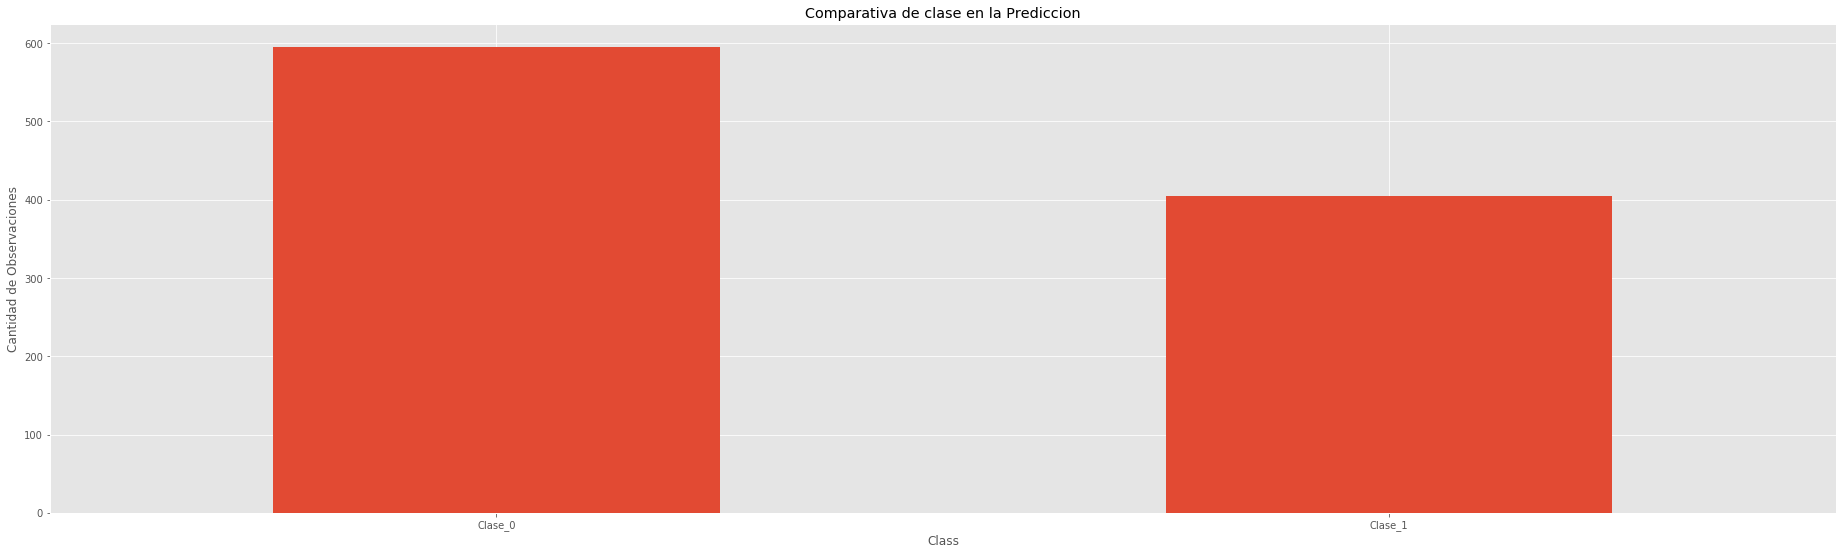

In [85]:
count_classes = pd.value_counts(dataframe_prediccion['Prediccion Ponderada'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Comparativa de clase en la Prediccion")
plt.xlabel("Class")
plt.ylabel("Cantidad de Observaciones")

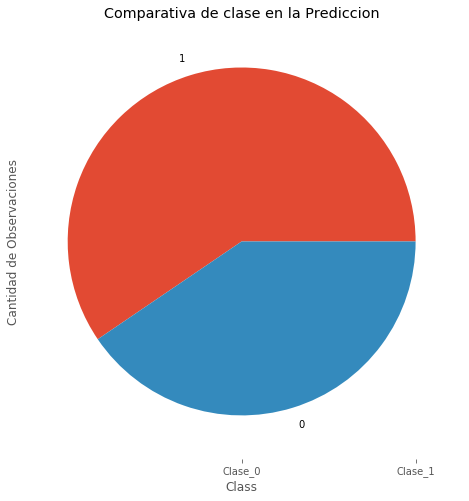

In [86]:
count_classes = pd.value_counts(dataframe_prediccion['Prediccion Ponderada'], sort = True)
count_classes.plot.pie(y='mass', figsize=(8, 8))
plt.xticks(range(2), LABELS)
plt.title("Comparativa de clase en la Prediccion")
plt.xlabel("Class")
plt.ylabel("Cantidad de Observaciones");

In [87]:
# obtiene el tiempo de ejecucion hasta esta linea
calcular_tiempo_de_ejecucion(time.time(), tiempo_inicial_ejecucion_notebook)

El tiempo de ejecucion actual en segundos es: 1177.861
El tiempo de ejecucion actual en minutos es: 19.631
